In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, SecondLocator, DateFormatter
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path

import inference
import learning
import torch

import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02
from aeon.analysis.utils import visits, distancetravelled

In [2]:
!ls /ceph/aeon

aeon			 aeon_transfer.log  rmhzbm0  test2
aeon_transfer_final.log  db_dumps	    test


In [3]:
# Long, individual session
root = [Path("/ceph/aeon/aeon/data/raw/AEON2/experiment0.2")]

# Ensure root exists
if not np.all([path.exists() for path in root]):
    print("Cannot find root paths. Check path names or connection.")

In [4]:
Exp02Summary = api.load(root, exp02.Metadata).metadata[0].toDict()
Patch_Pos = [device['Regions']['ArrayOfPoint'] for device in Exp02Summary['Devices'] if device['Name'].startswith('ActivityPatch')]

In [6]:
subject_events = api.load(root, exp02.ExperimentalMetadata.SubjectState)
sessions = visits(subject_events[subject_events.id.str.startswith("BAA-")])

# Load mice 15 - BAA-1100703
start, end = pd.Timestamp("2022-05-25 09:00:00"), pd.Timestamp("2022-05-25 09:05:00")
mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)

In [7]:
pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)
pellets_patch2 = api.load(root, exp02.Patch2.DeliverPellet, start=start, end=end)
aeon.load(root, exp02.ExperimentMetadata.Messagelog, start = start, end = end)

Empty DataFrame
Columns: [_typ, dtype, ndim]
Index: []

In [8]:
date_times = pd.to_datetime(mouse_pos.index)
dt = (date_times[1]-date_times[0]).total_seconds()

In [9]:
# State
pos_x0, pos_y0 = obs[0, 0], obs[1, 0]
vel_x0, vel_y0 = 0.0, 0.0
acc_x0, acc_y0 = 0.0, 0.0

sigma_a = 0.1
sqrt_diag_V0_value = 1e-3

m0 = np.array([pos_x0, vel_x0, acc_x0, pos_y0, vel_y0, acc_y0], dtype=np.double)
V0 = np.diag(np.ones(len(m0))*sqrt_diag_V0_value**2)

B = np.array([[1, dt, .5*dt**2, 0, 0, 0],
               [0, 1, dt, 0, 0, 0],
               [0, 0, 1, 0, 0, 0],
               [0, 0, 0, 1, dt, .5*dt**2],
               [0, 0, 0, 0, 1, dt],
               [0, 0, 0, 0, 0, 1]],
              dtype=np.double)

Qe = np.array([[dt**4/4, dt**3/2, dt**2/2, 0, 0, 0],
               [dt**3/2, dt**2,   dt,      0, 0, 0],
               [dt**2/2, dt,      1,       0, 0, 0],
               [0, 0, 0, dt**4/4, dt**3/2, dt**2/2],
               [0, 0, 0, dt**3/2, dt**2,   dt],
               [0, 0, 0, dt**2/2, dt,      1]],
              dtype=np.double)
Q = sigma_a**2 * Qe


# Observation 
sigma_x = 1
sigma_y = 1

Z = np.array([[1, 0, 0, 0, 0, 0],
               [0, 0, 0, 1, 0, 0]],
              dtype=np.double)
R = np.diag([sigma_x**2, sigma_y**2])

/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/inference.py:225: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  innov.T @ Sinv @ innov


--------------------------------------------------------------------------------
epoch: 0
likelihood: -2778539.315587009
sigma_a: 
tensor([0.1090], requires_grad=True)
sqrt_diag_R: 
tensor([1.0005, 1.0005], dtype=torch.float64, requires_grad=True)
m0: 
tensor([ 1.1285e+03, -2.3144e-07, -1.5194e-07,  3.7708e+02, -1.0394e-06,
        -3.9285e-07], dtype=torch.float64, requires_grad=True)
sqrt_diag_V0: 
tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010], dtype=torch.float64,
       requires_grad=True)
--------------------------------------------------------------------------------
epoch: 1
likelihood: -2556324.892472157
sigma_a: 
tensor([0.1239], requires_grad=True)
sqrt_diag_R: 
tensor([1.0016, 1.0018], dtype=torch.float64, requires_grad=True)
m0: 
tensor([ 1.1285e+03, -6.3143e-07, -4.1088e-07,  3.7708e+02, -3.4789e-06,
        -1.2070e-06], dtype=torch.float64, requires_grad=True)
sqrt_diag_V0: 
tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010], dtype=torch.float64,
       re

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2079: RuntimeWarning: overflow encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2079: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


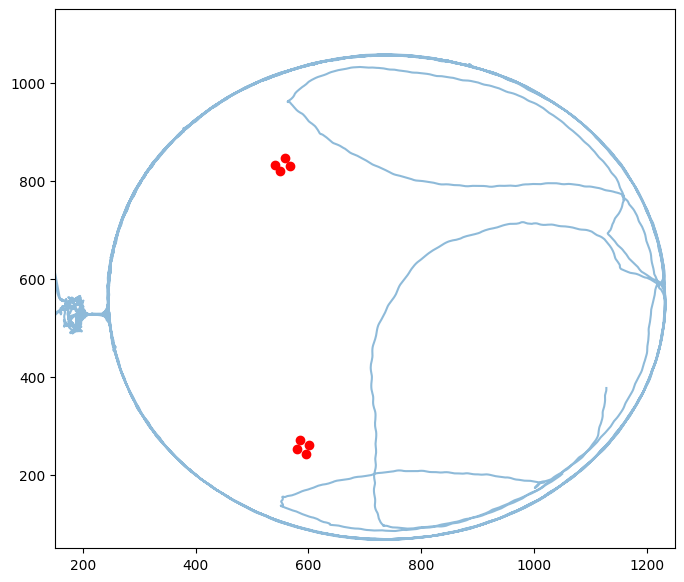

In [14]:
# Run time: 57min 45s
skip_estimation_sigma_a = False
skip_estimation_R = False
skip_estimation_m0 = False
skip_estimation_V0 = False

lbfgs_max_iter = 2
lbfgs_tolerance_grad = -1
lbfgs_tolerance_change = 1e-3
lbfgs_lr = 0.01
lbfgs_n_epochs = 75
lbfgs_tol = 1e-3
Qe_reg_param_learned = 1e-2
sqrt_diag_R_torch = torch.DoubleTensor([sigma_x, sigma_y])
m0_torch = torch.from_numpy(m0.copy())
sqrt_diag_V0_torch = torch.DoubleTensor([sqrt_diag_V0_value for i in range(len(m0))])
if Qe_reg_param_learned is not None:
    Qe_regularized_learned = Qe + Qe_reg_param_learned * np.eye(Qe.shape[0])
else:
    Qe_regularized_learned = Qe
y_torch = torch.from_numpy(obs.astype(np.double))
B_torch = torch.from_numpy(B.astype(np.double))
Qe_regularized_learned_torch = torch.from_numpy(Qe_regularized_learned.astype(np.double))
Z_torch = torch.from_numpy(Z.astype(np.double))

vars_to_estimate = {}
if skip_estimation_sigma_a:
    vars_to_estimate["sigma_a"] = False
else:
    vars_to_estimate["sigma_a"] = True

if skip_estimation_R:
    vars_to_estimate["sqrt_diag_R"] = False
    vars_to_estimate["R"] = False
else:
    vars_to_estimate["sqrt_diag_R"] = True
    vars_to_estimate["R"] = True

if skip_estimation_m0:
    vars_to_estimate["m0"] = False
else:
    vars_to_estimate["m0"] = True

if skip_estimation_V0:
    vars_to_estimate["sqrt_diag_V0"] = False
    vars_to_estimate["V0"] = False
else:
    vars_to_estimate["sqrt_diag_V0"] = True
    vars_to_estimate["V0"] = True

optim_res_learned = learning.torch_lbfgs_optimize_SS_tracking_diagV0(
    y=y_torch, B=B_torch, sigma_a0=sigma_a,
    Qe=Qe_regularized_learned_torch, Z=Z_torch, sqrt_diag_R_0=sqrt_diag_R_torch, m0_0=m0_torch,
    sqrt_diag_V0_0=sqrt_diag_V0_torch, max_iter=lbfgs_max_iter, lr=lbfgs_lr,
    vars_to_estimate=vars_to_estimate, tolerance_grad=lbfgs_tolerance_grad,
    tolerance_change=lbfgs_tolerance_change, n_epochs=lbfgs_n_epochs,
    tol=lbfgs_tol)


Q_learned = optim_res_learned["estimates"]["sigma_a"].item()**2*Qe
m0_learned = optim_res_learned["estimates"]["m0"].numpy()
V0_learned = np.diag(optim_res_learned["estimates"]["sqrt_diag_V0"].numpy()**2)
R_learned = np.diag(optim_res_learned["estimates"]["sqrt_diag_R"].numpy()**2)

In [17]:
np.savez("20231122Param.npz", Q = Q_learned, m0 = m0_learned, V0 = V0_learned, R = R_learned)

In [19]:
Paras = np.load("20231122Param.npz")
Q, m0, V0, R = Paras['Q'], Paras['m0'], Paras['V0'], Paras['R']

In [29]:
def GenerateTime(d, h, m, s):
    m += int(s/60)
    s = s%60
    
    h += int(m/60)
    m = m%60
    
    if h < 10: h = '0' + str(h)
    else: h = str(h)
    if m<10: m = '0' + str(m)
    else: m = str(m)
    if s < 10: s = '0' + str(s)
    else: s = str(s)
    
    return d + " " + h + ":" + m + ":" + s 

2022-05-25 09:00:00
2022-05-25 09:05:00


/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2079: RuntimeWarning: overflow encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2079: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


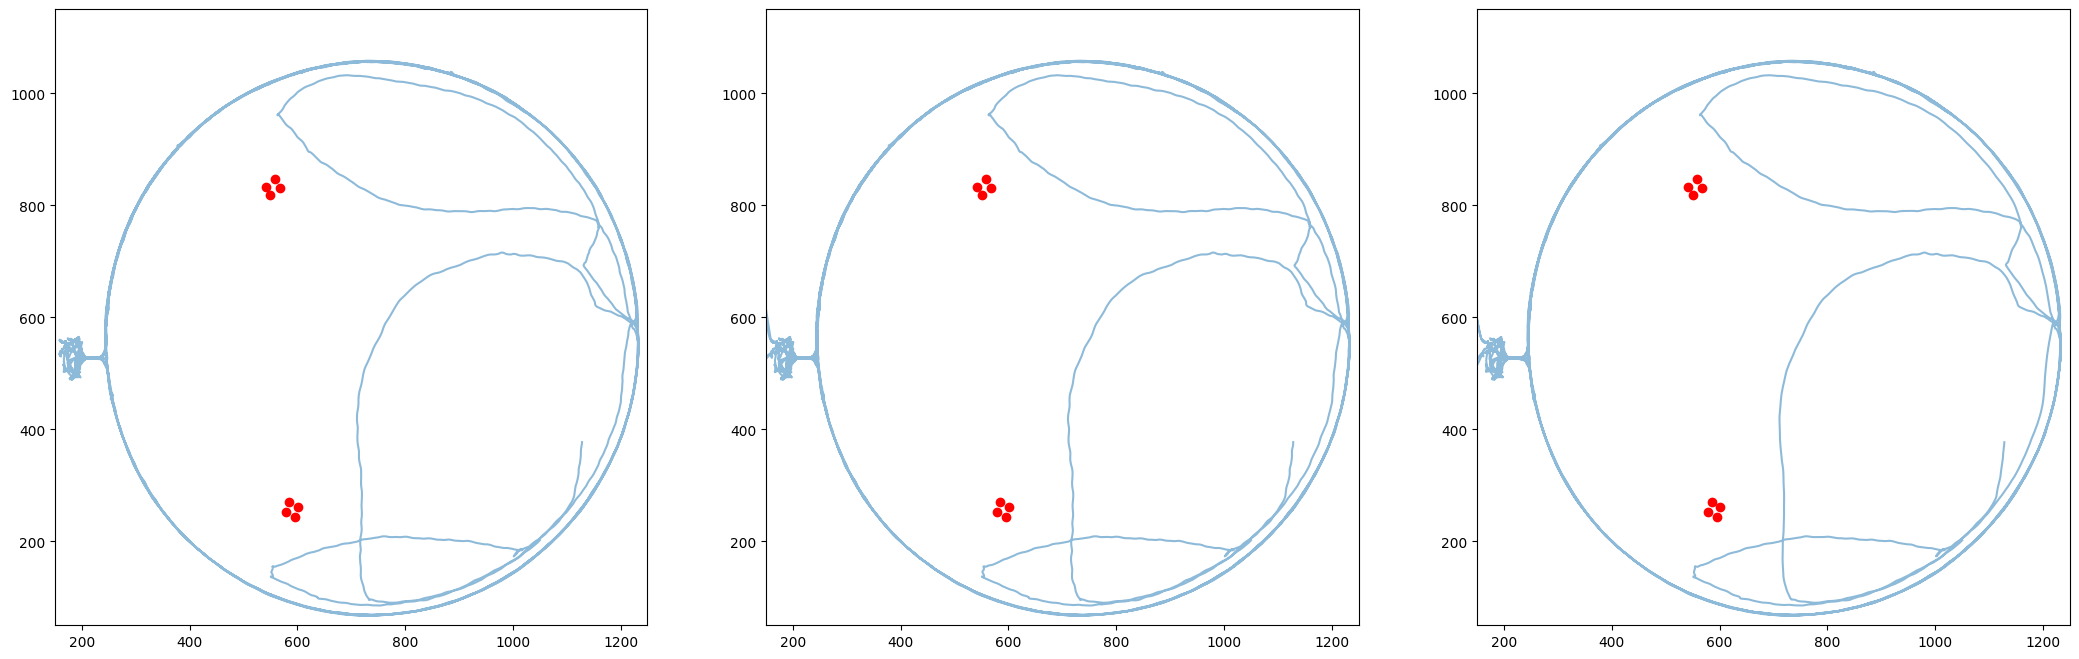

2022-05-25 09:05:00
2022-05-25 09:10:00


/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2079: RuntimeWarning: overflow encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2079: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


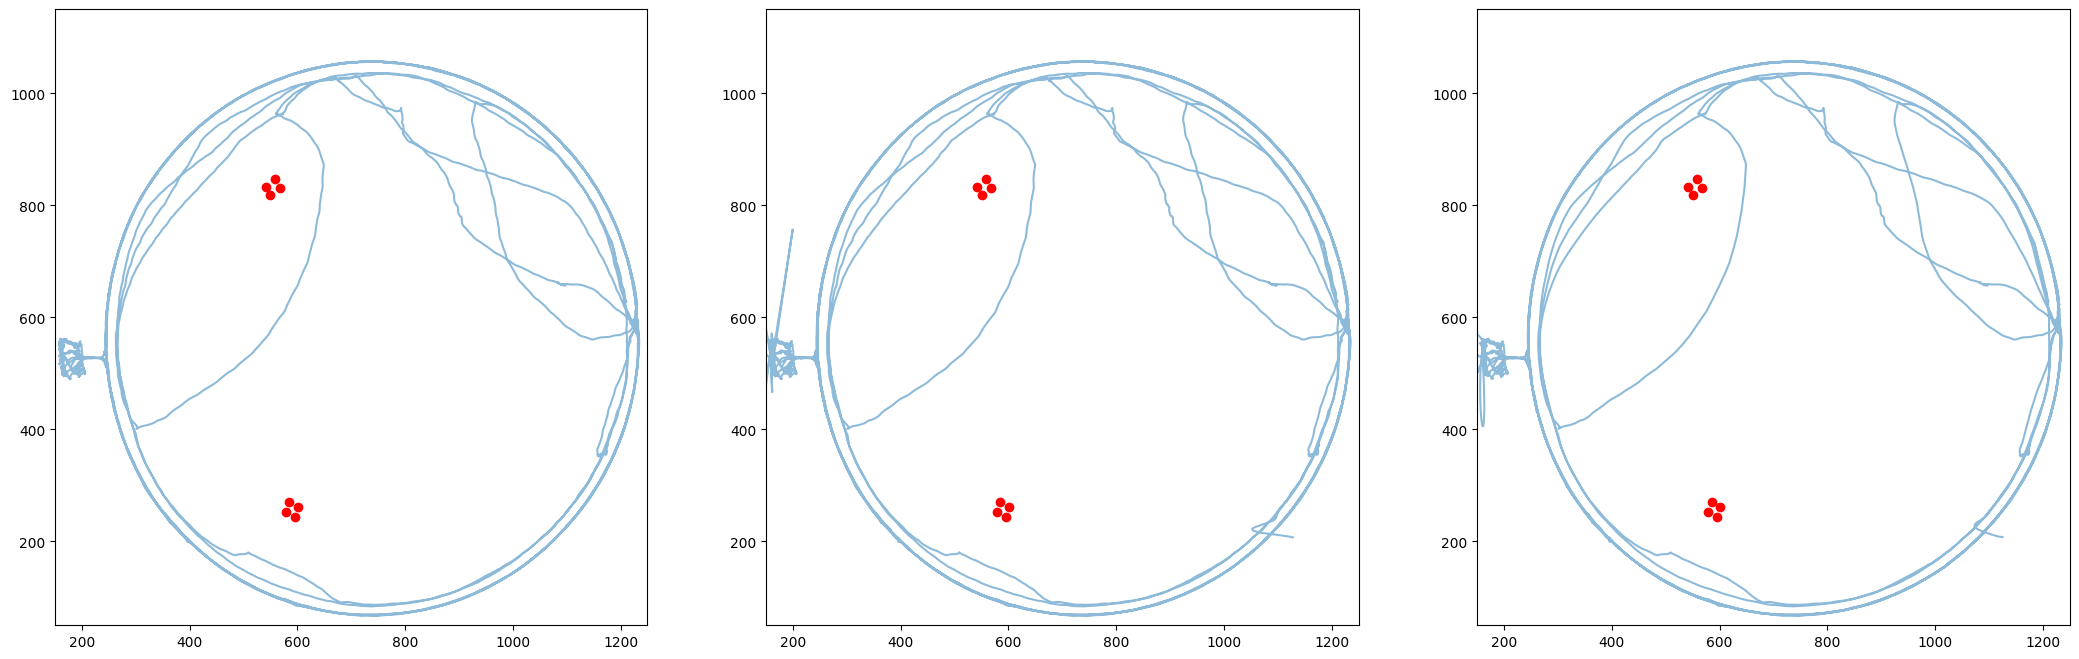

2022-05-25 09:10:00
2022-05-25 09:15:00


/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2079: RuntimeWarning: overflow encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2079: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/inference.py:359: RuntimeWarning: overflow encountered in matmul
  logLike = logLike-np.linalg.slogdet(Sn[:, :, k])[1] - innov[:, :, k].T @ Sinv @ innov[:, :, k]


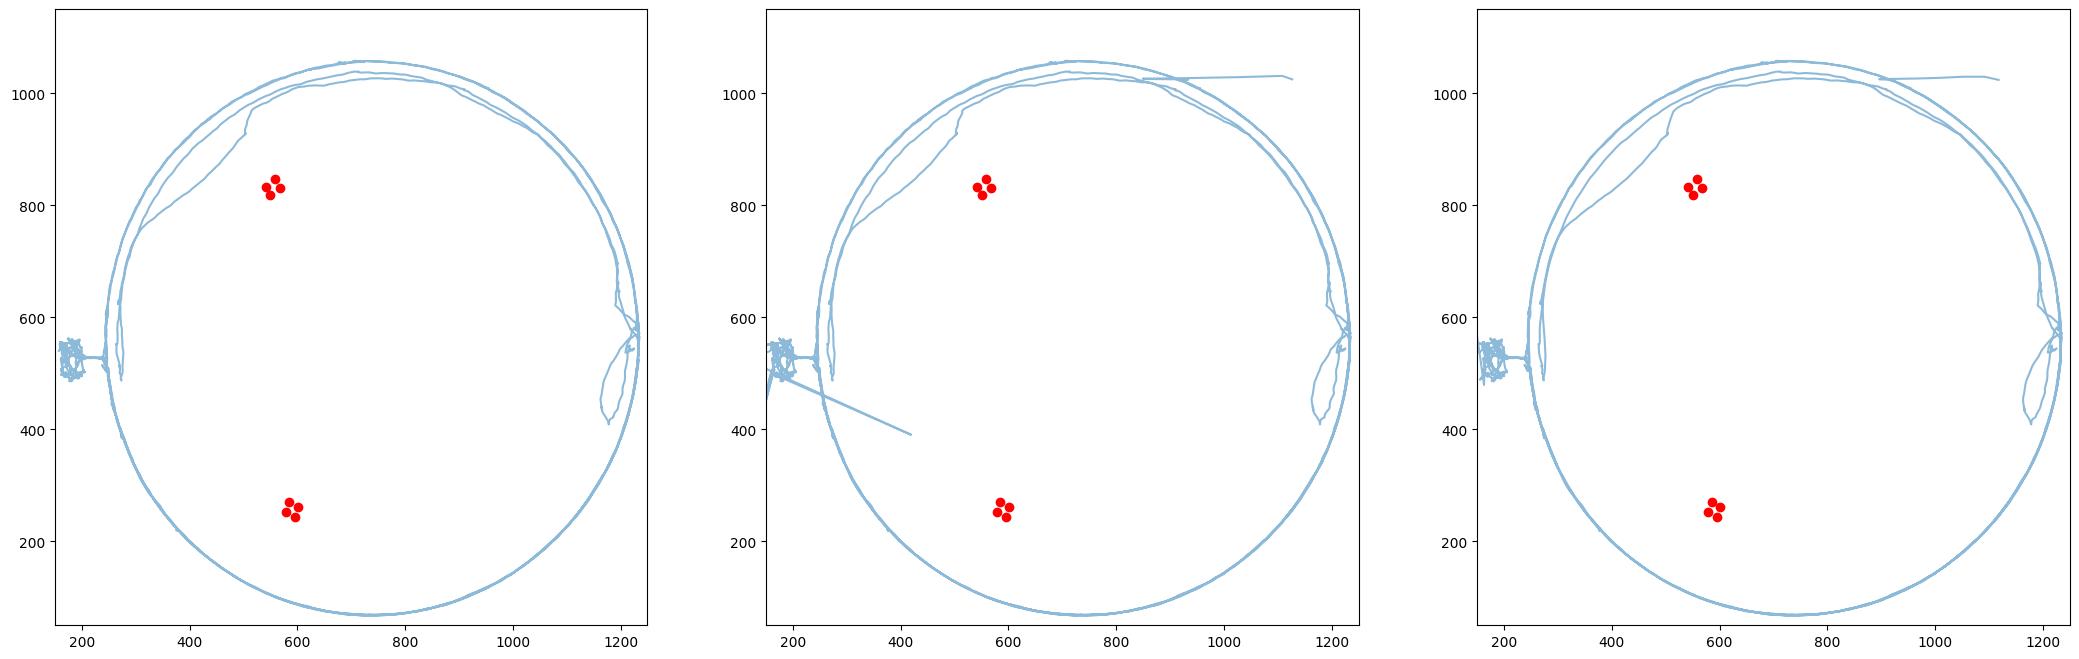

2022-05-25 09:15:00
2022-05-25 09:20:00


/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/inference.py:359: RuntimeWarning: overflow encountered in matmul
  logLike = logLike-np.linalg.slogdet(Sn[:, :, k])[1] - innov[:, :, k].T @ Sinv @ innov[:, :, k]
/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/inference.py:359: RuntimeWarning: invalid value encountered in subtract
  logLike = logLike-np.linalg.slogdet(Sn[:, :, k])[1] - innov[:, :, k].T @ Sinv @ innov[:, :, k]


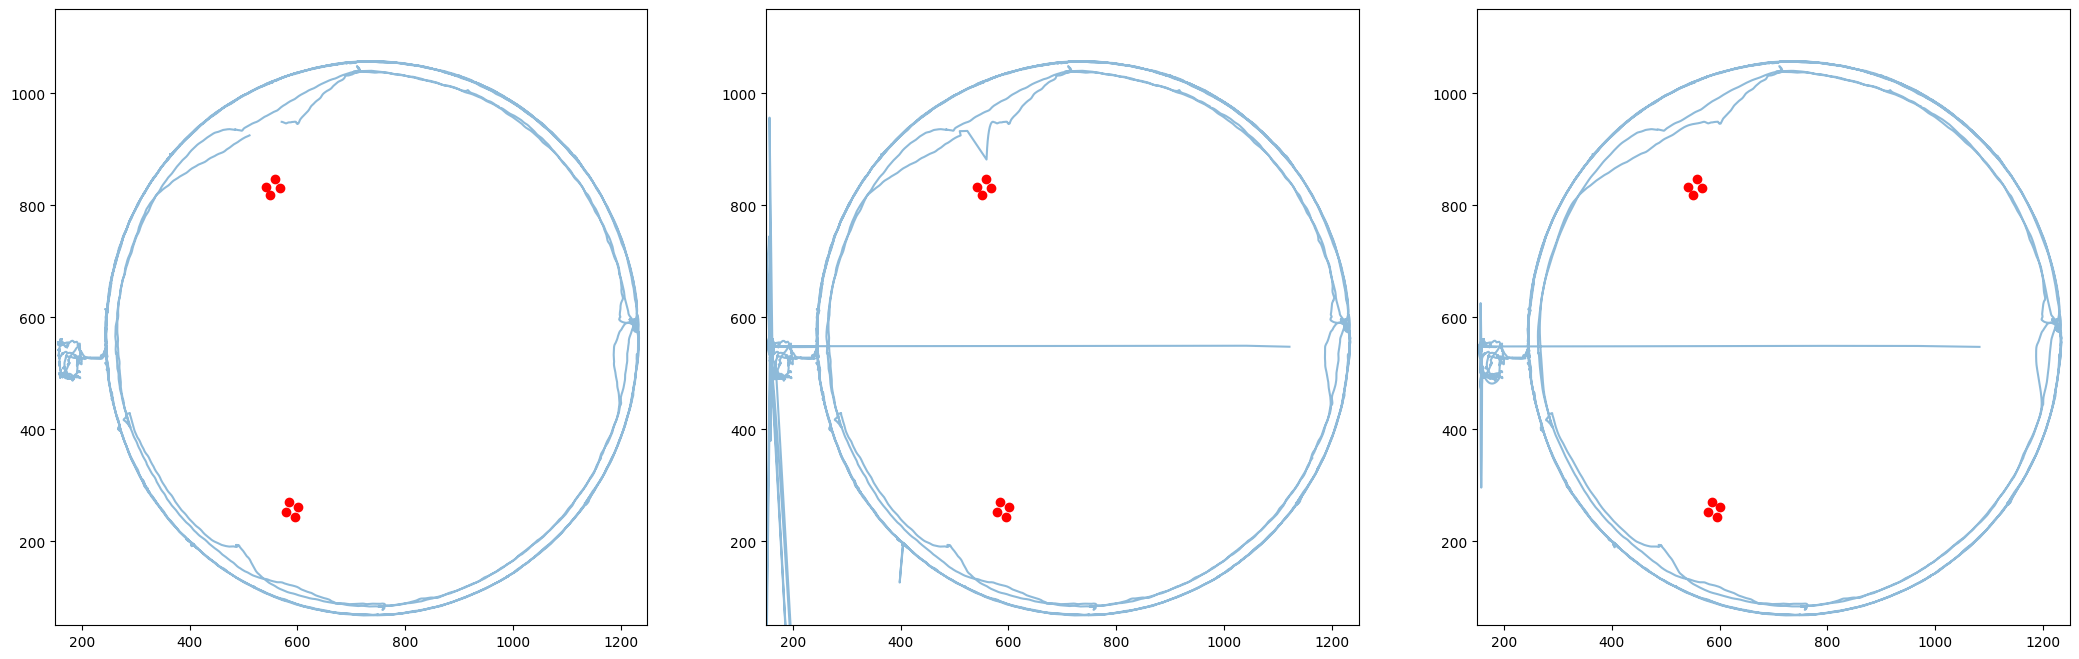

2022-05-25 09:20:00
2022-05-25 09:25:00


/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2079: RuntimeWarning: overflow encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2079: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


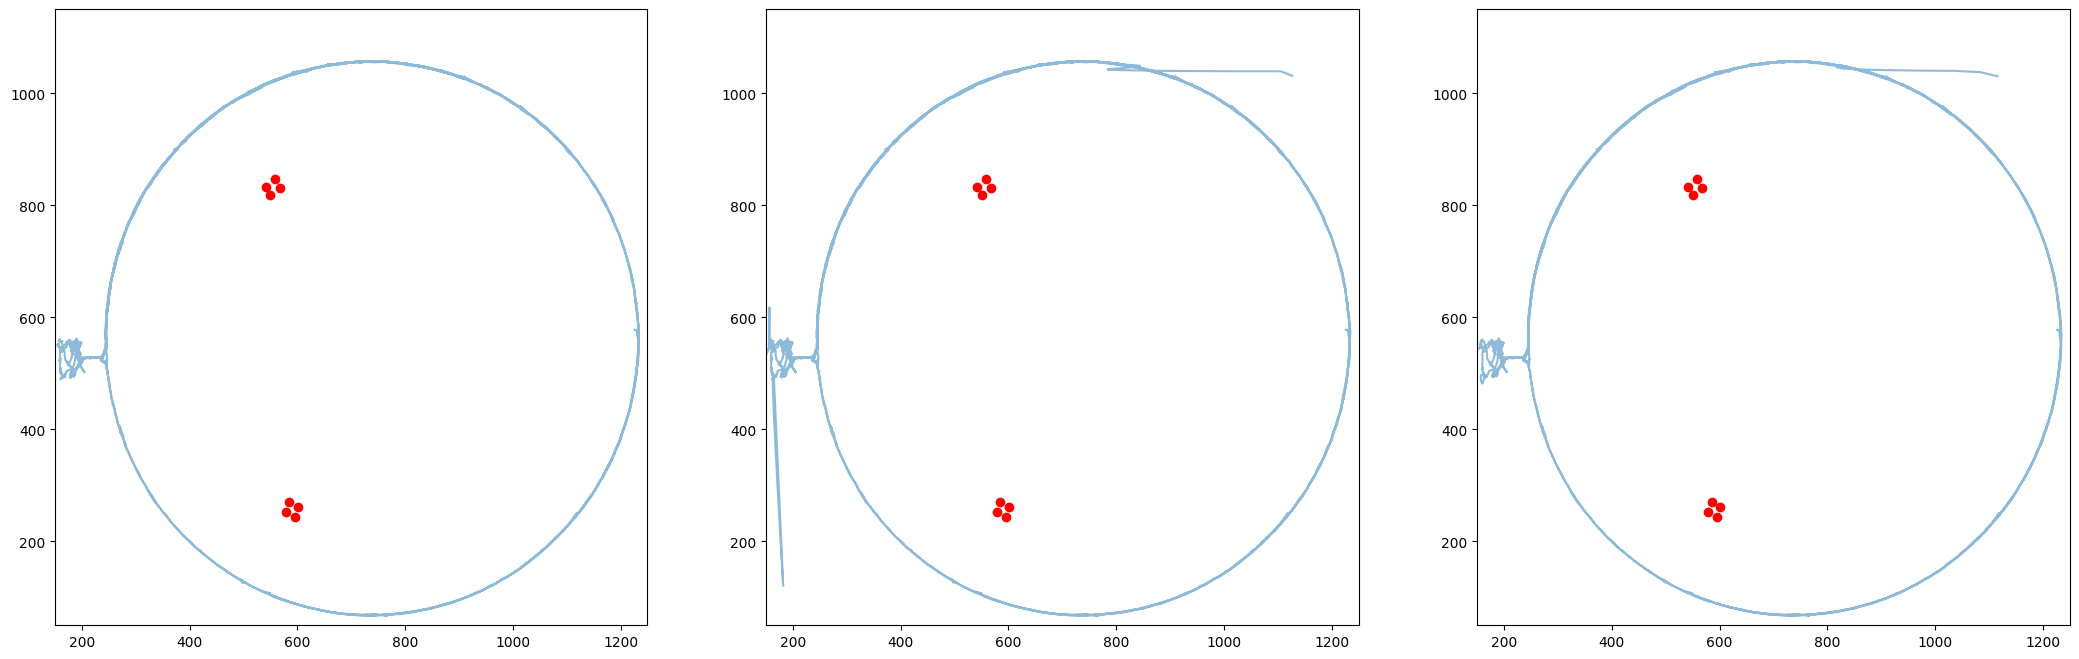

2022-05-25 09:25:00
2022-05-25 09:30:00


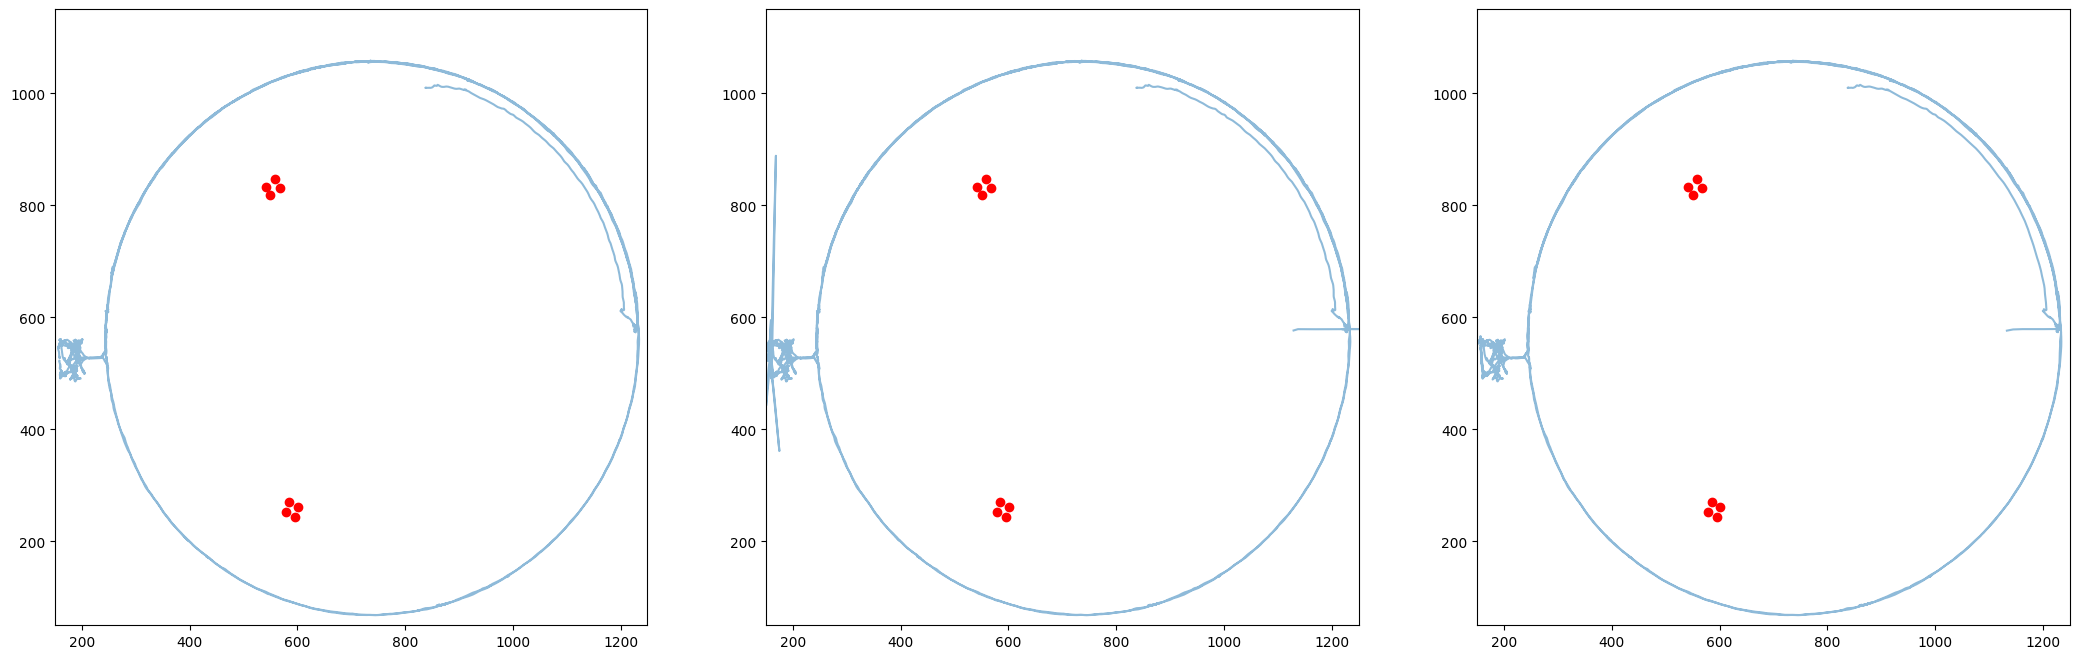

2022-05-25 09:30:00
2022-05-25 09:35:00


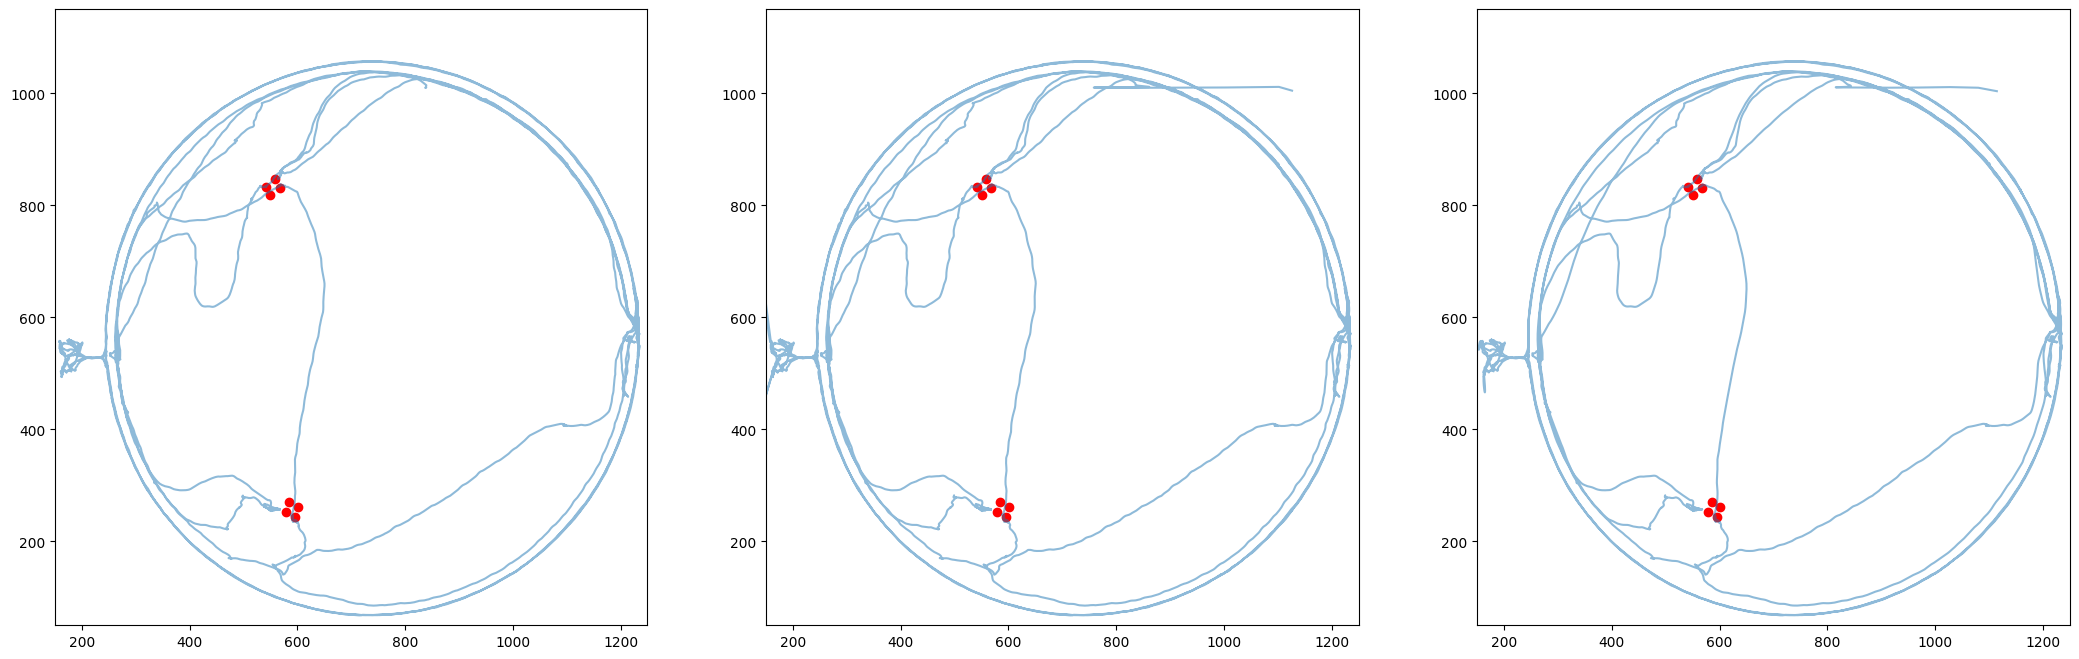

2022-05-25 09:35:00
2022-05-25 09:40:00


/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/inference.py:359: RuntimeWarning: overflow encountered in matmul
  logLike = logLike-np.linalg.slogdet(Sn[:, :, k])[1] - innov[:, :, k].T @ Sinv @ innov[:, :, k]


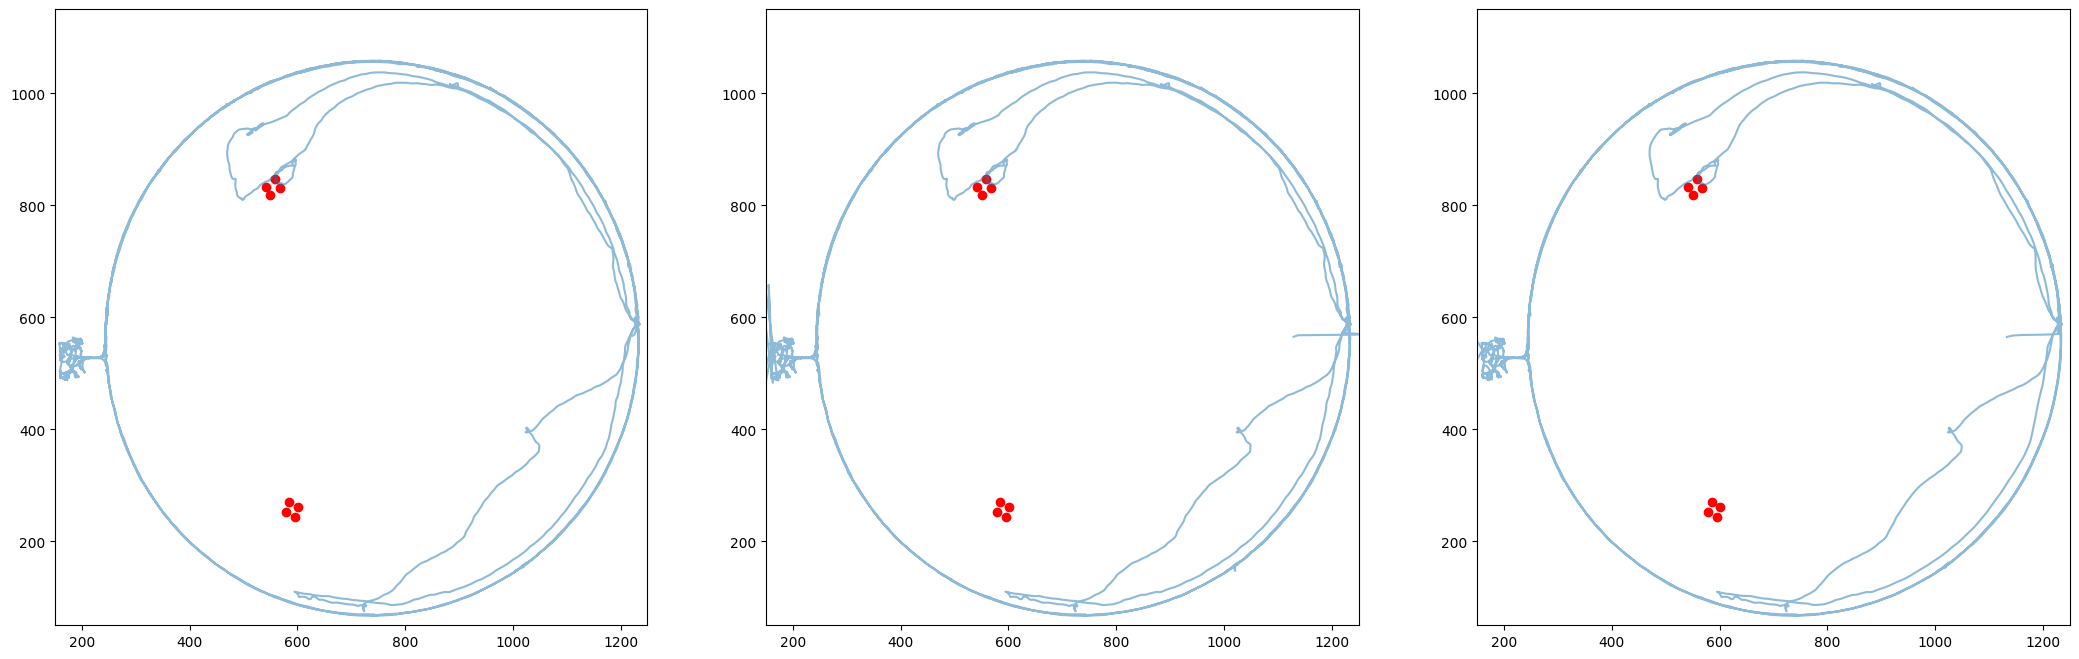

2022-05-25 09:40:00
2022-05-25 09:45:00


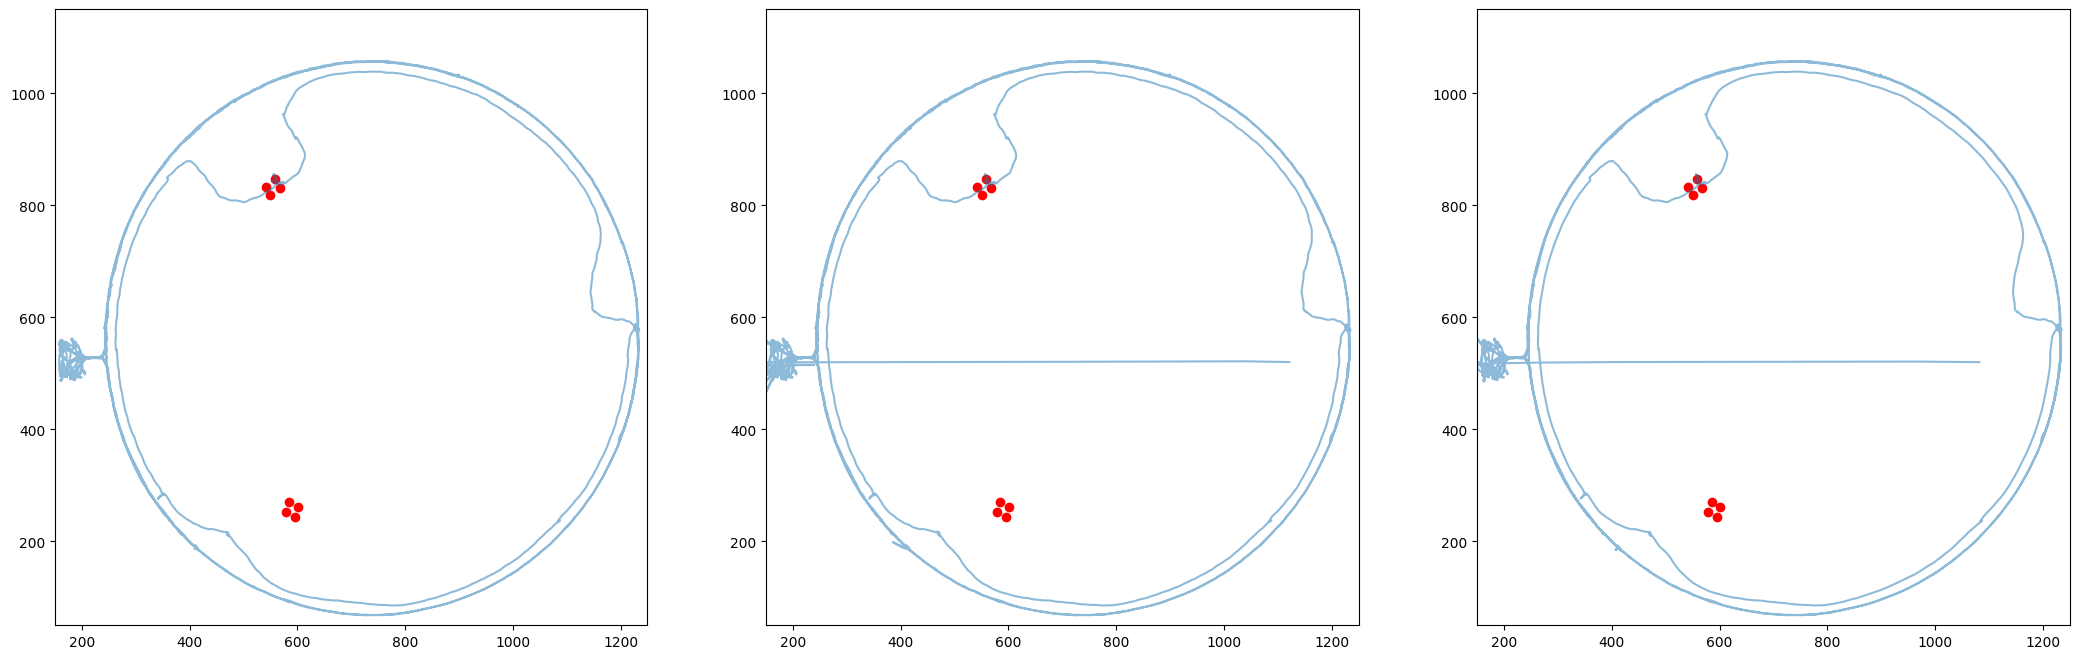

2022-05-25 09:45:00
2022-05-25 09:50:00


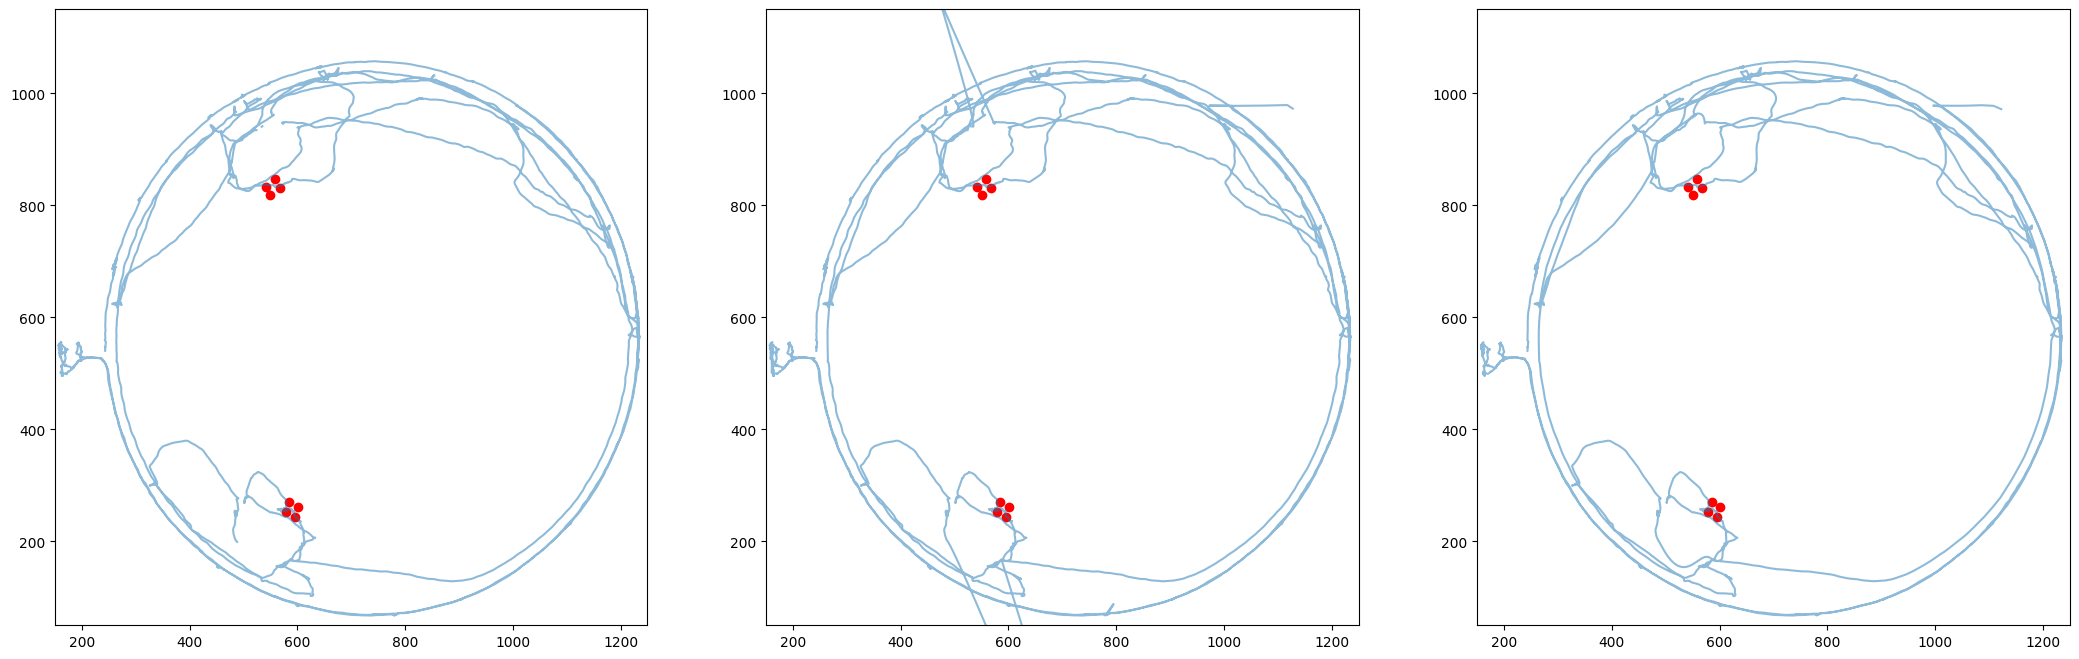

2022-05-25 09:50:00
2022-05-25 09:55:00


/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2079: RuntimeWarning: overflow encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2079: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


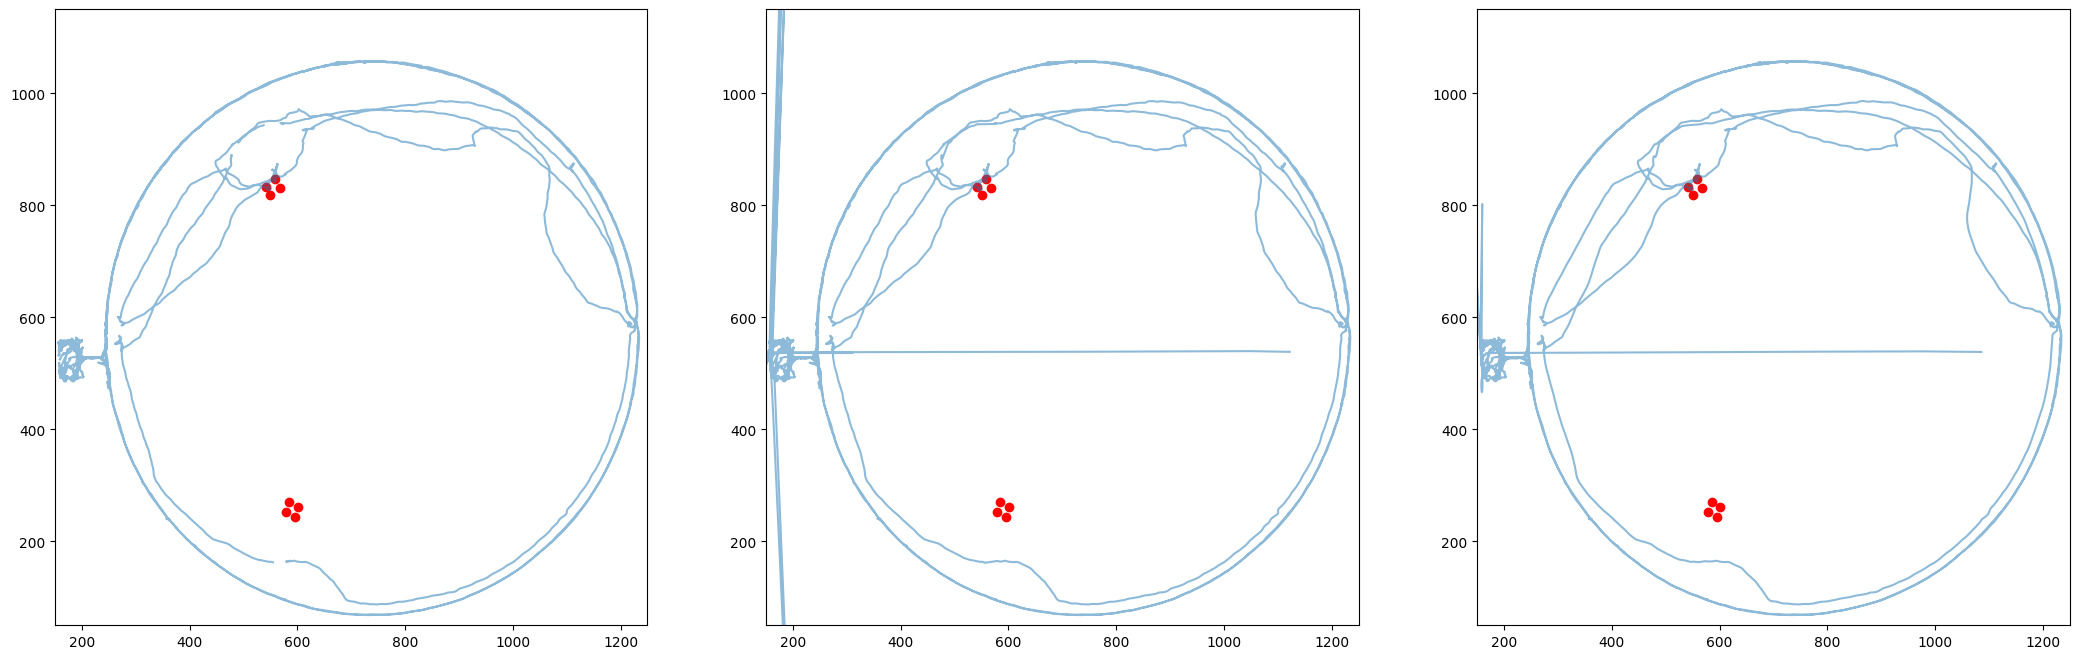

2022-05-25 09:55:00
2022-05-25 10:00:00


/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/inference.py:359: RuntimeWarning: overflow encountered in matmul
  logLike = logLike-np.linalg.slogdet(Sn[:, :, k])[1] - innov[:, :, k].T @ Sinv @ innov[:, :, k]


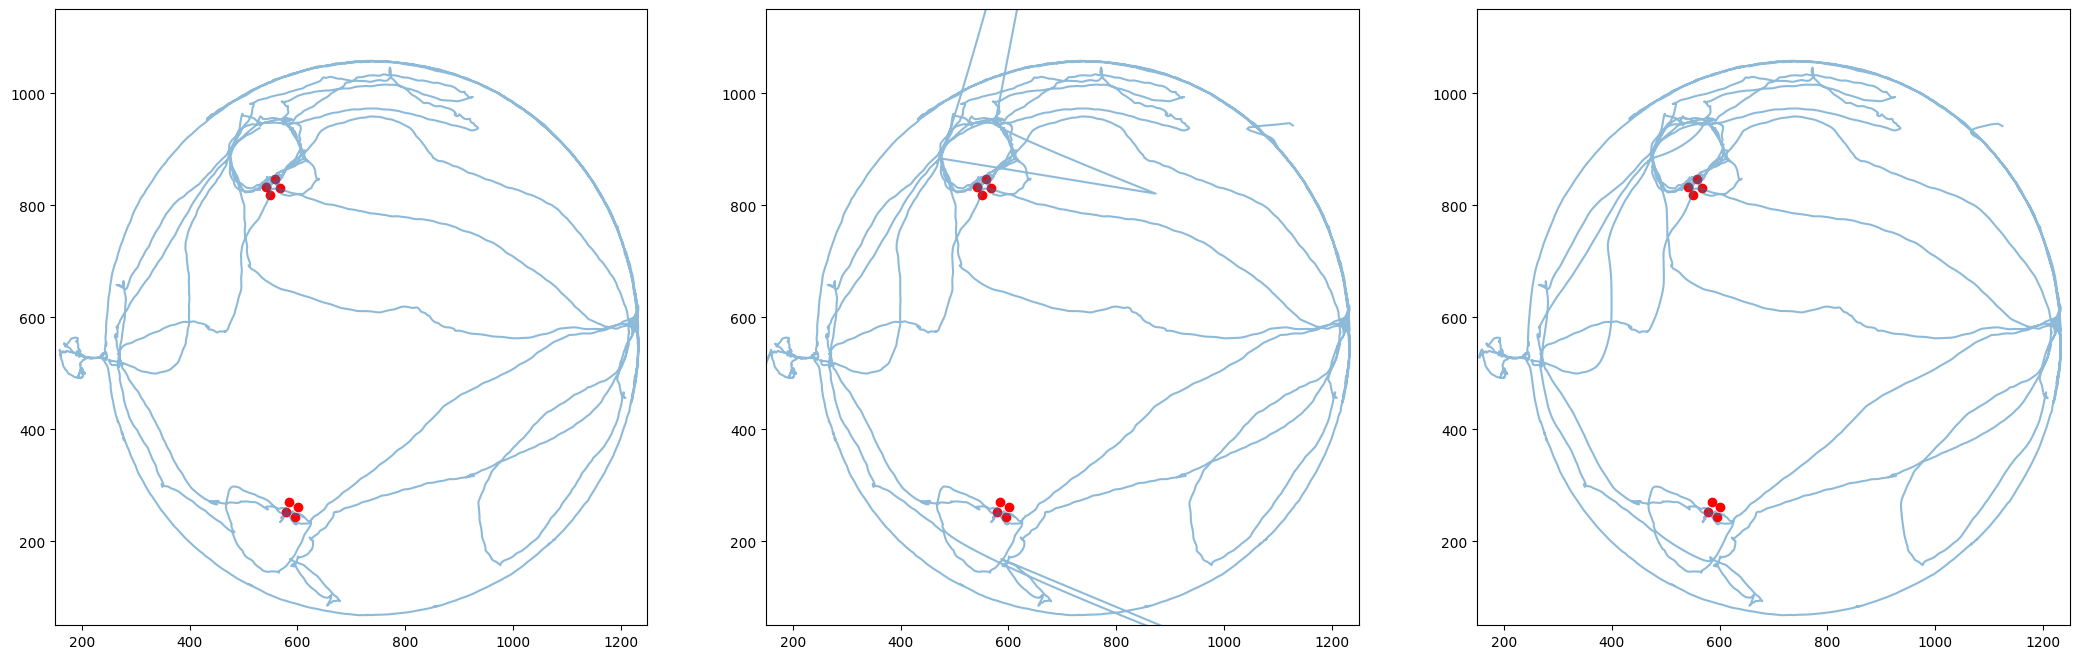

In [33]:
# Load mice 15 - BAA-1100703
for i in range(0, 12):
    start_time, end_time = GenerateTime(d='2022-05-25', h=9,m=i*5,s=0), GenerateTime(d='2022-05-25', h=9,m=(i+1)*5,s=0)
    start, end = pd.Timestamp(start_time), pd.Timestamp(end_time)
    print(start)
    print(end)
    
    mouse_sub_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
    obs = np.transpose(mouse_sub_pos[["x", "y"]].to_numpy())


    filterRes = inference.filterLDS_SS_withMissingValues_np(
        y=obs, B=B, Q=Q, m0=m0, V0=V0, Z=Z, R=R)
    filter_mean_x = filterRes["xnn"][0][0]
    filter_mean_y = filterRes["xnn"][3][0]

    smoothRes = inference.smoothLDS_SS(
        B=B, xnn=filterRes["xnn"], Vnn=filterRes["Vnn"],
        xnn1=filterRes["xnn1"], Vnn1=filterRes["Vnn1"], m0=m0, V0=V0)

    smoothed_mean_x = smoothRes['xnN'][0][0]
    smoothed_mean_y = smoothRes['xnN'][3][0]

    xlim, ylim = (150, 1250), (50, 1150)
    fig, axs = plt.subplots(1, 3, figsize = (26,8))
    axs[0].plot(obs[0], obs[1], alpha=0.5)
    axs[0].set_xlim(xlim)
    axs[0].set_ylim(ylim)

    axs[1].plot(filter_mean_x, filter_mean_y, alpha=0.5)
    axs[1].set_xlim(xlim)
    axs[1].set_ylim(ylim)

    axs[2].plot(smoothed_mean_x, smoothed_mean_y, alpha=0.5)
    axs[2].set_xlim(xlim)
    axs[2].set_ylim(ylim)

    for patch in Patch_Pos:
        patch_pos = [(int(pos['X']), int(pos['Y'])) for pos in patch]
        for pos in patch_pos: 
            axs[0].scatter(pos[0], pos[1], color = 'red')
            axs[1].scatter(pos[0], pos[1], color = 'red')
            axs[2].scatter(pos[0], pos[1], color = 'red')
    plt.show()

2022-05-25 12:00:00
2022-05-25 12:05:00


/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/inference.py:359: RuntimeWarning: overflow encountered in matmul
  logLike = logLike-np.linalg.slogdet(Sn[:, :, k])[1] - innov[:, :, k].T @ Sinv @ innov[:, :, k]


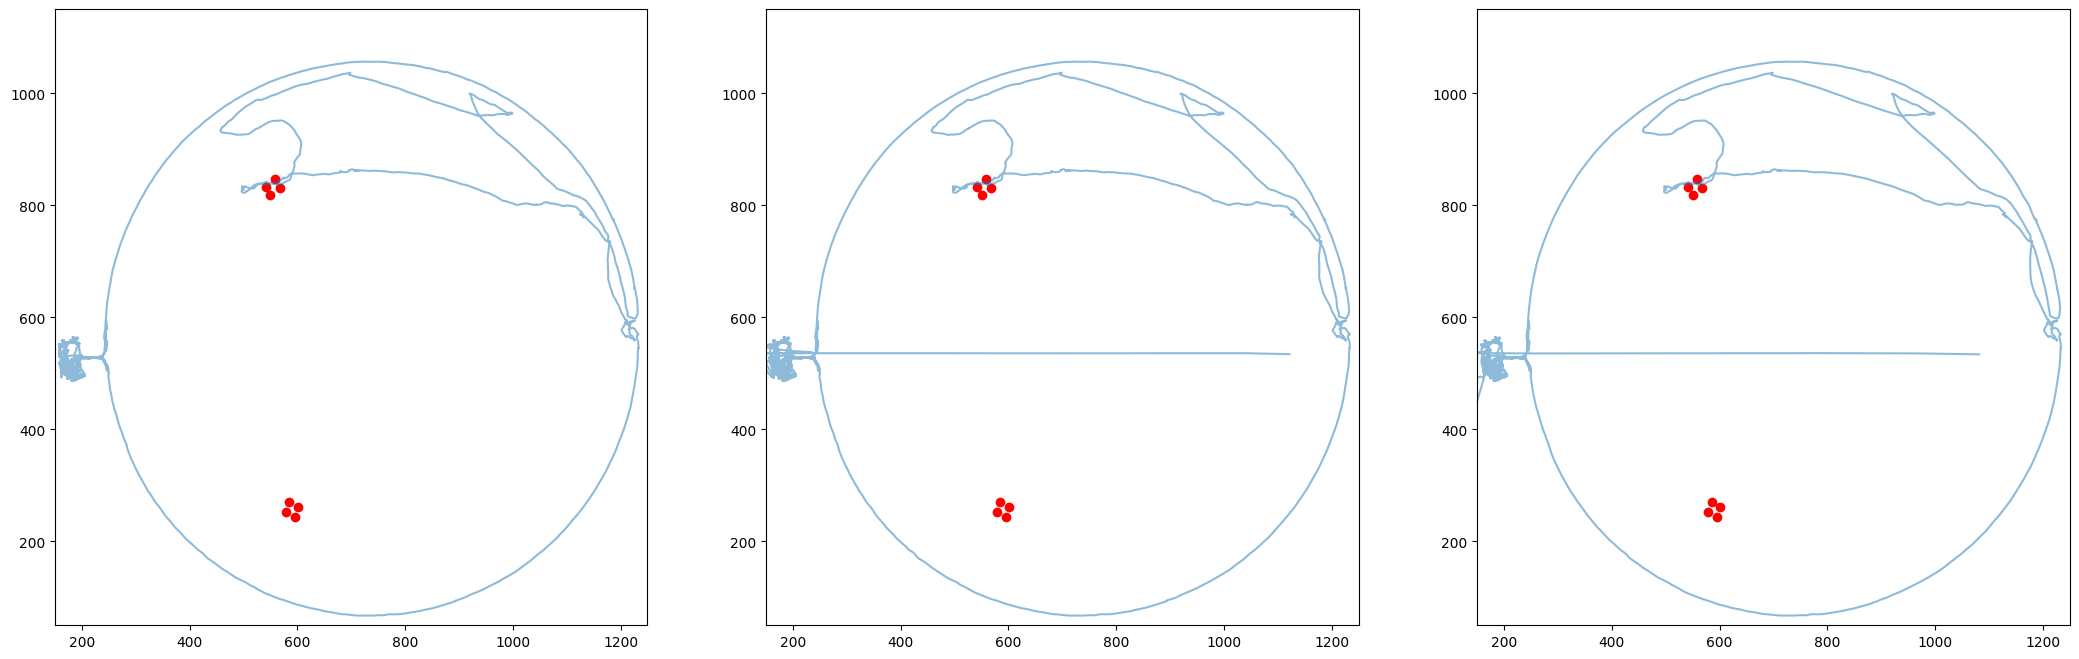

2022-05-25 12:05:00
2022-05-25 12:10:00


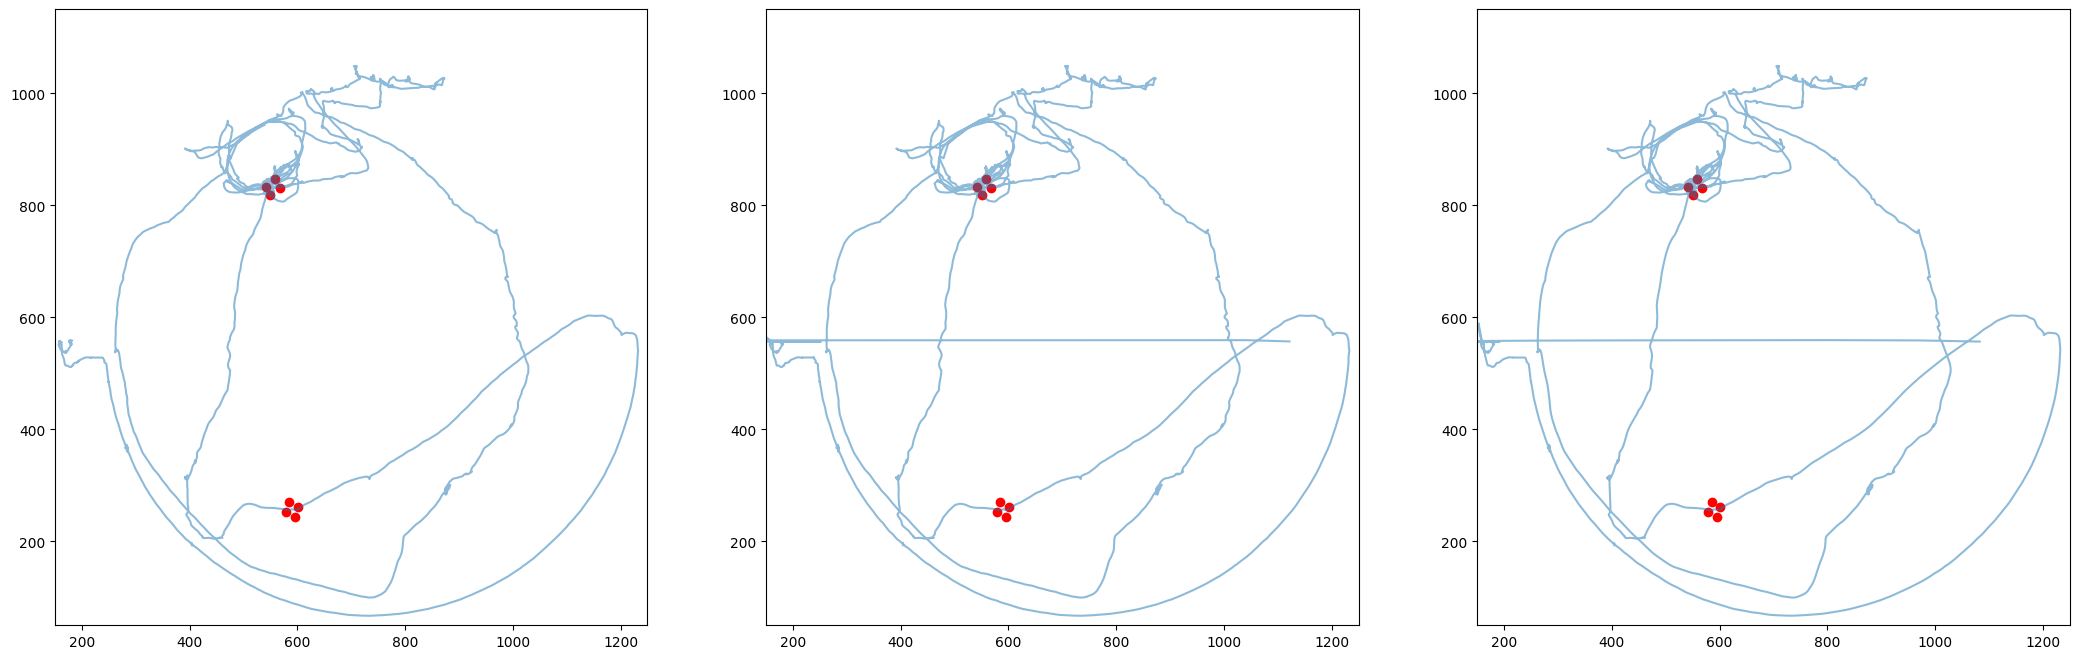

2022-05-25 12:10:00
2022-05-25 12:15:00


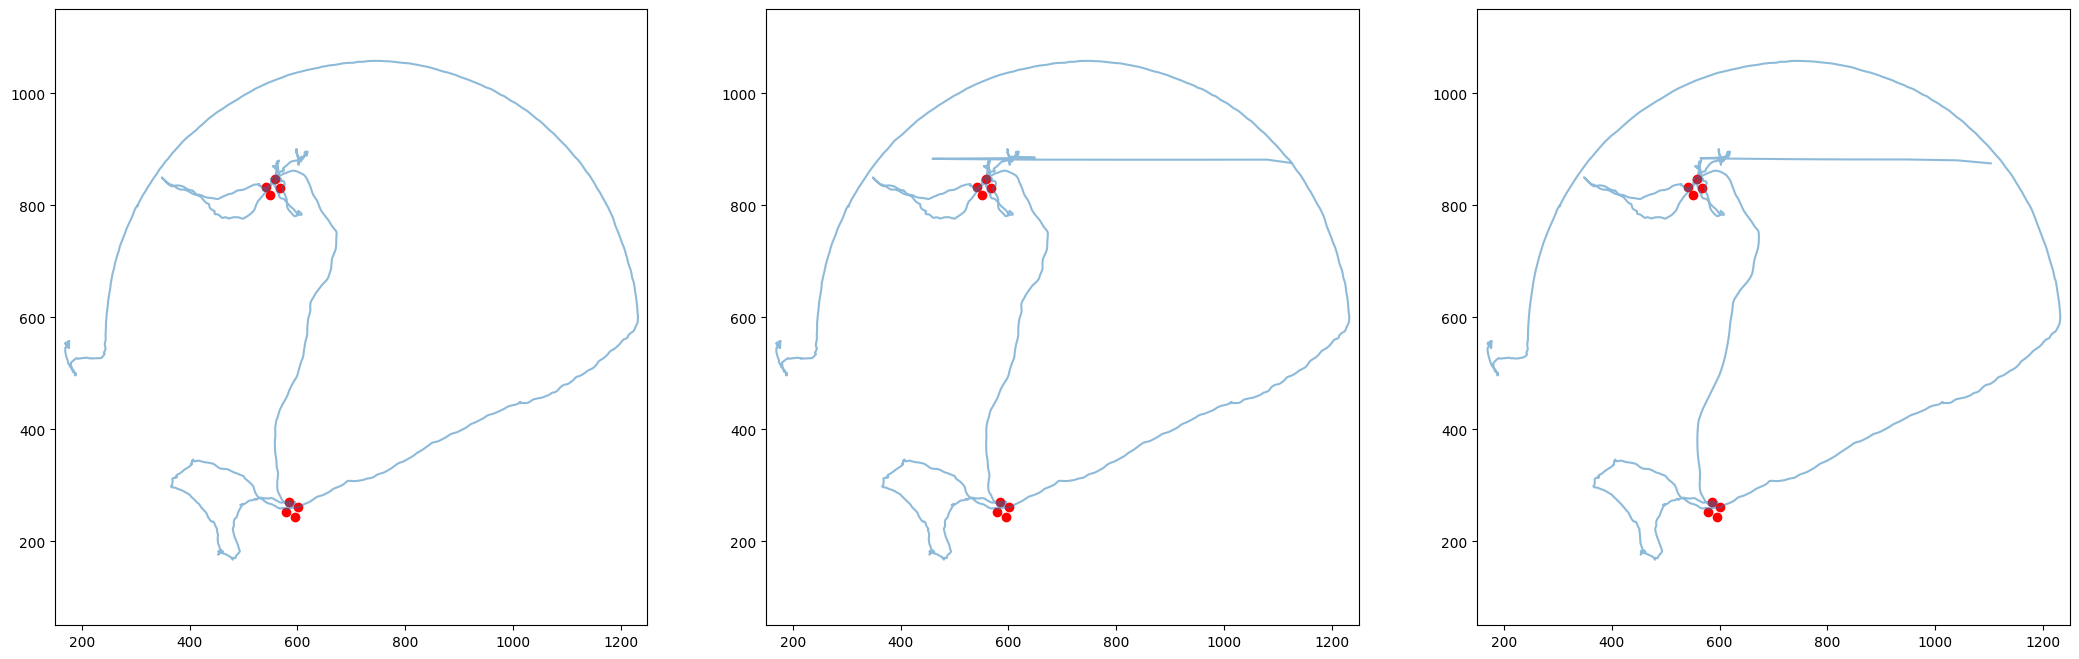

2022-05-25 12:15:00
2022-05-25 12:20:00


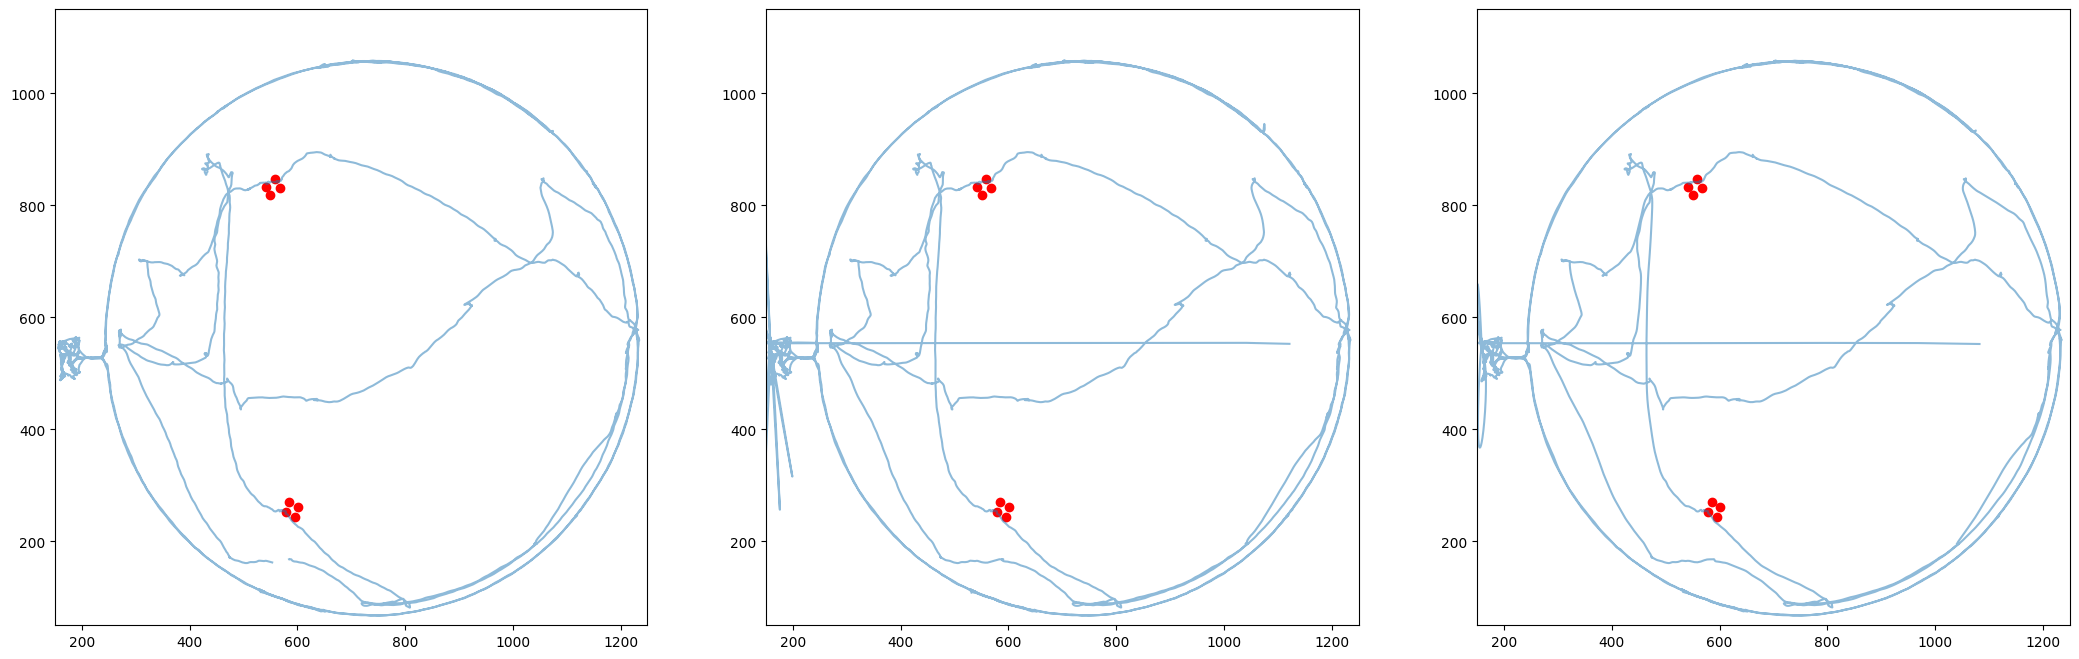

2022-05-25 12:20:00
2022-05-25 12:25:00


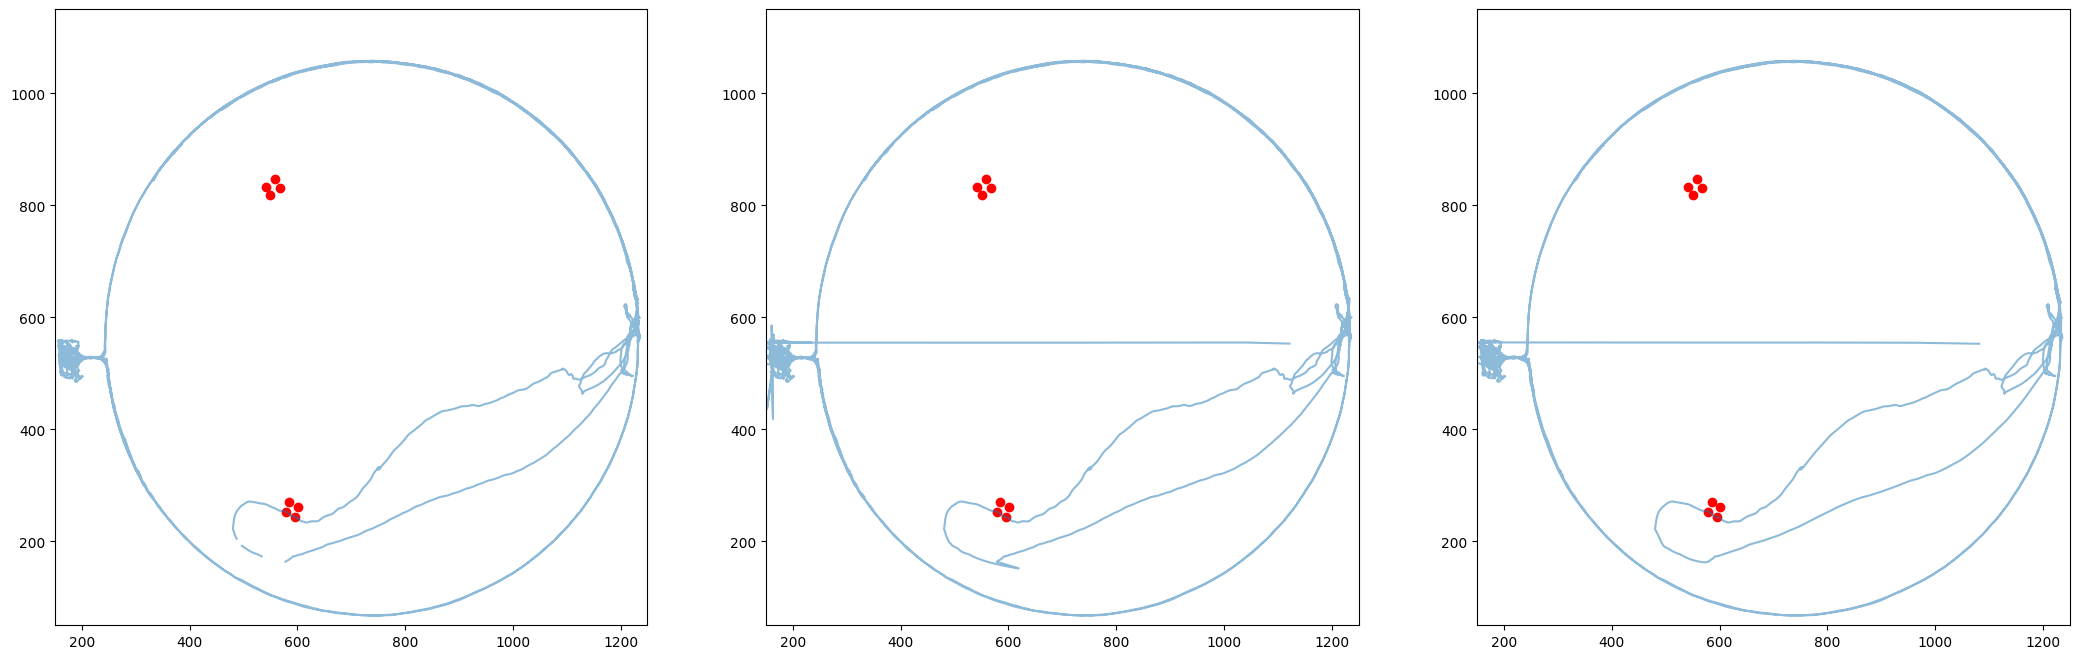

2022-05-25 12:25:00
2022-05-25 12:30:00


/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2079: RuntimeWarning: overflow encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/numpy/linalg/linalg.py:2079: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


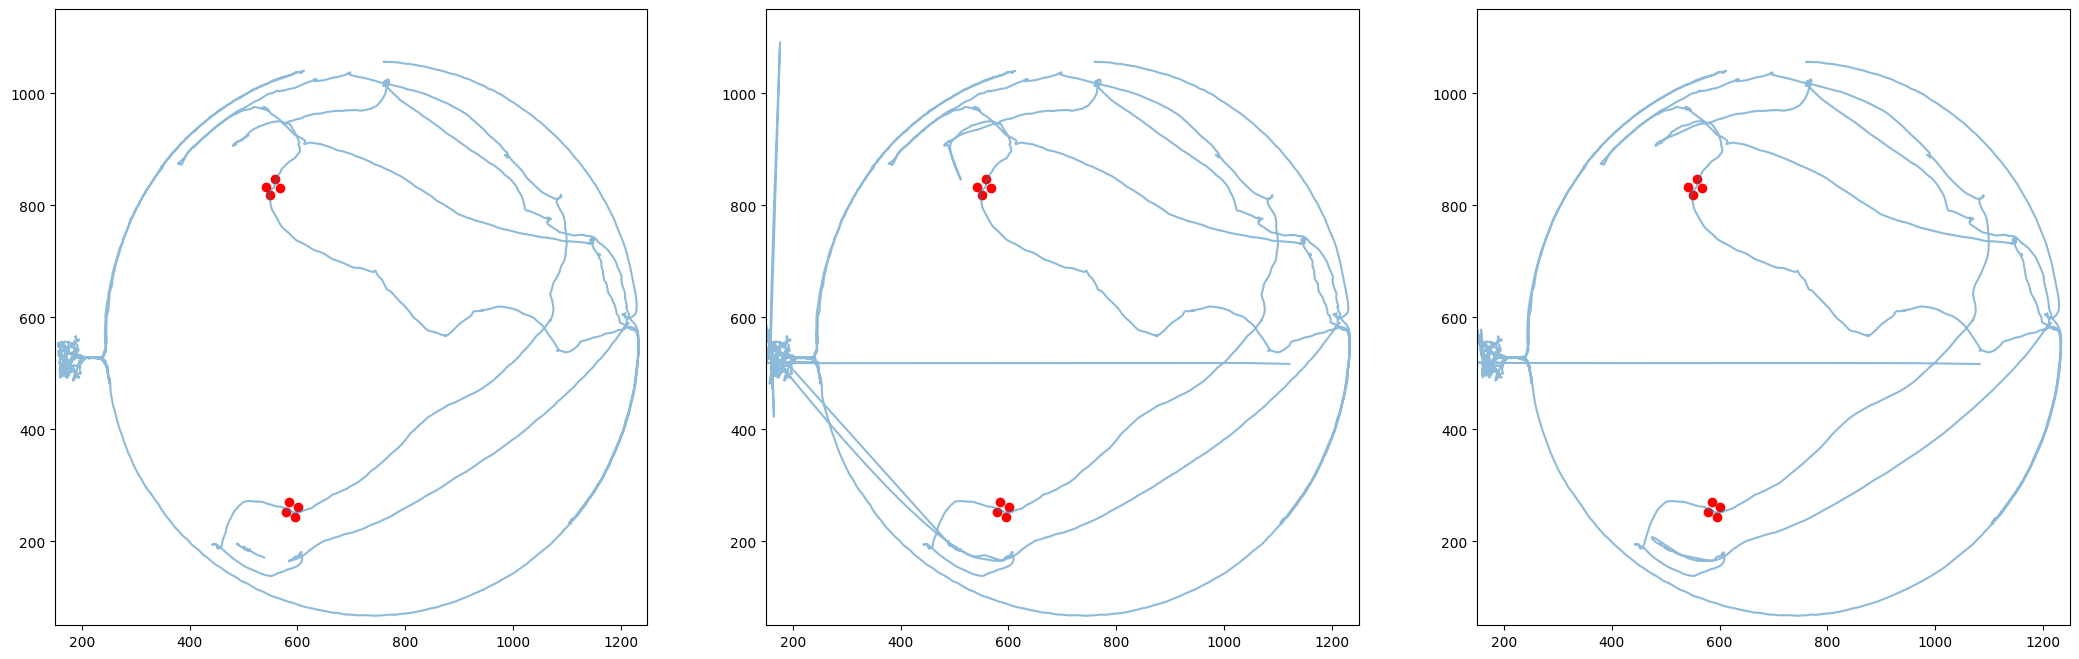

2022-05-25 12:30:00
2022-05-25 12:35:00


/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/inference.py:359: RuntimeWarning: overflow encountered in matmul
  logLike = logLike-np.linalg.slogdet(Sn[:, :, k])[1] - innov[:, :, k].T @ Sinv @ innov[:, :, k]


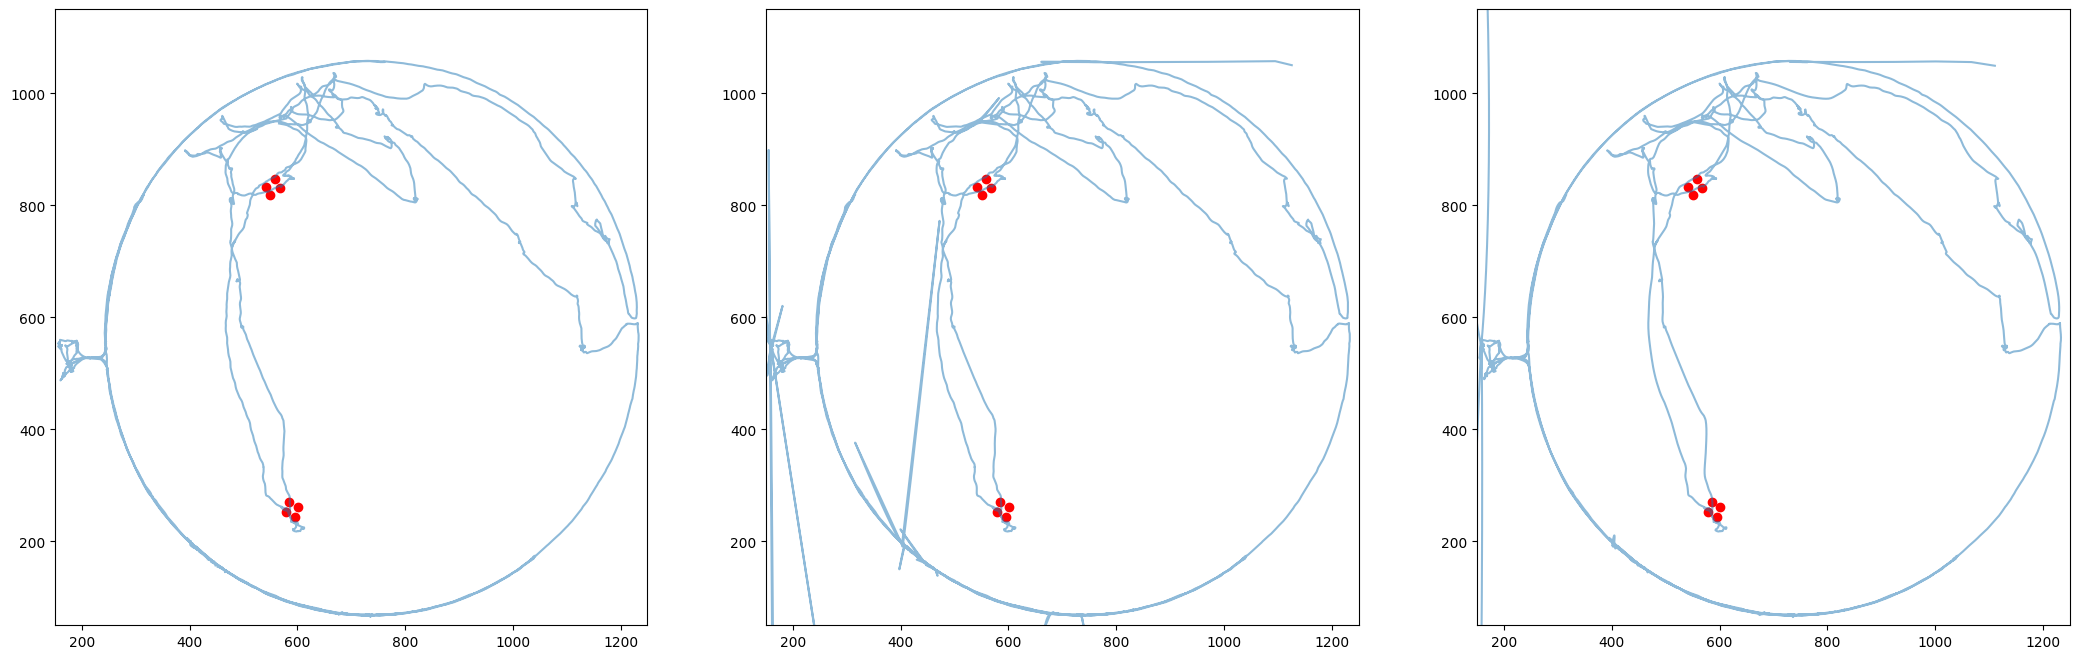

2022-05-25 12:35:00
2022-05-25 12:40:00


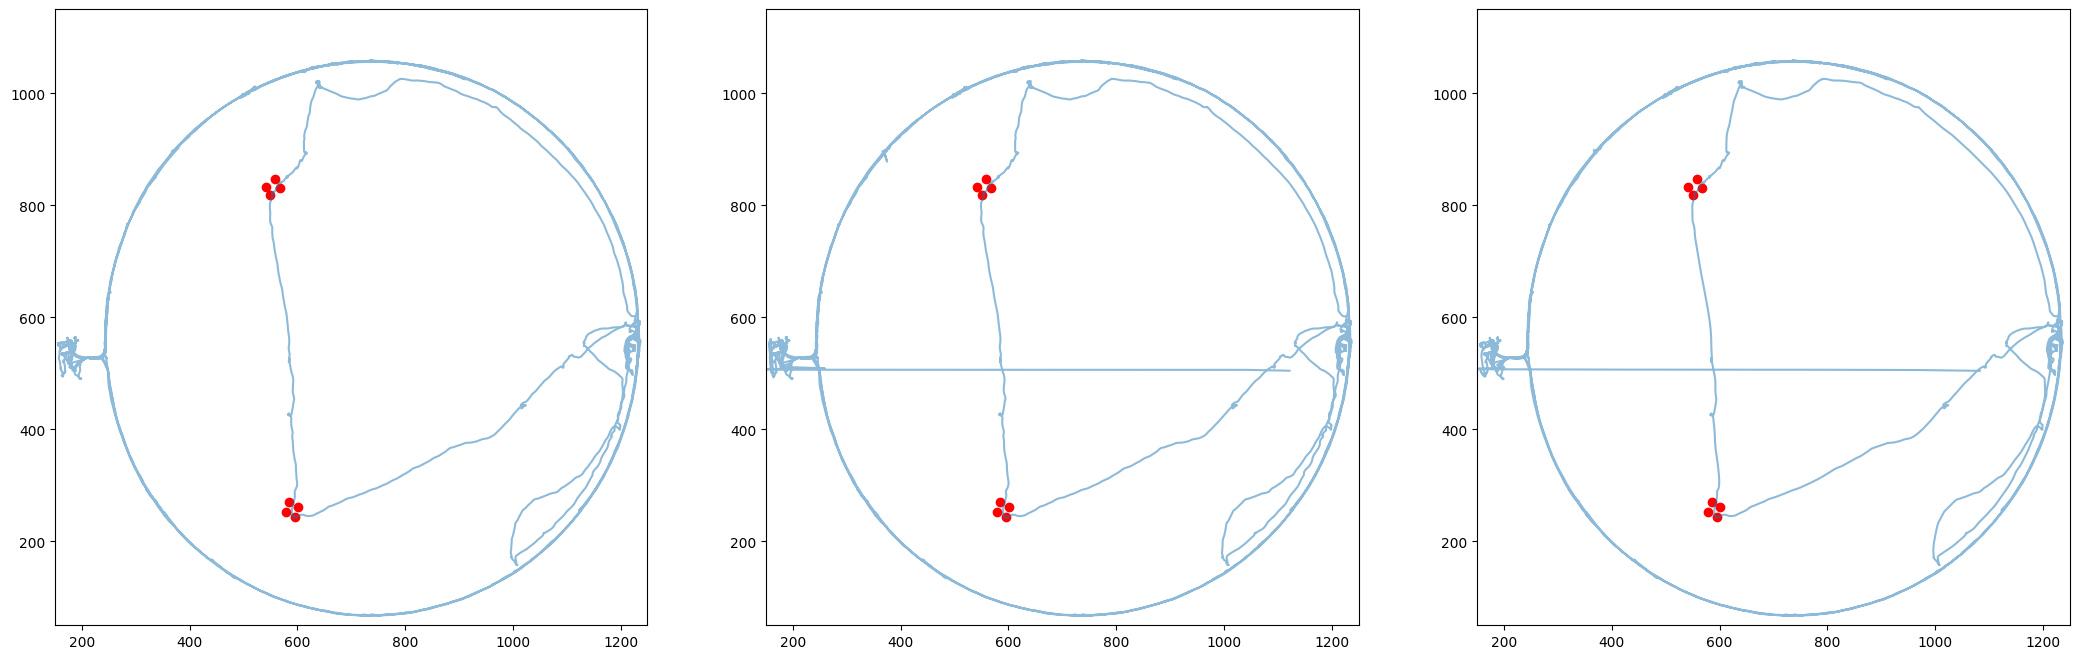

2022-05-25 12:40:00
2022-05-25 12:45:00


/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/inference.py:359: RuntimeWarning: overflow encountered in matmul
  logLike = logLike-np.linalg.slogdet(Sn[:, :, k])[1] - innov[:, :, k].T @ Sinv @ innov[:, :, k]


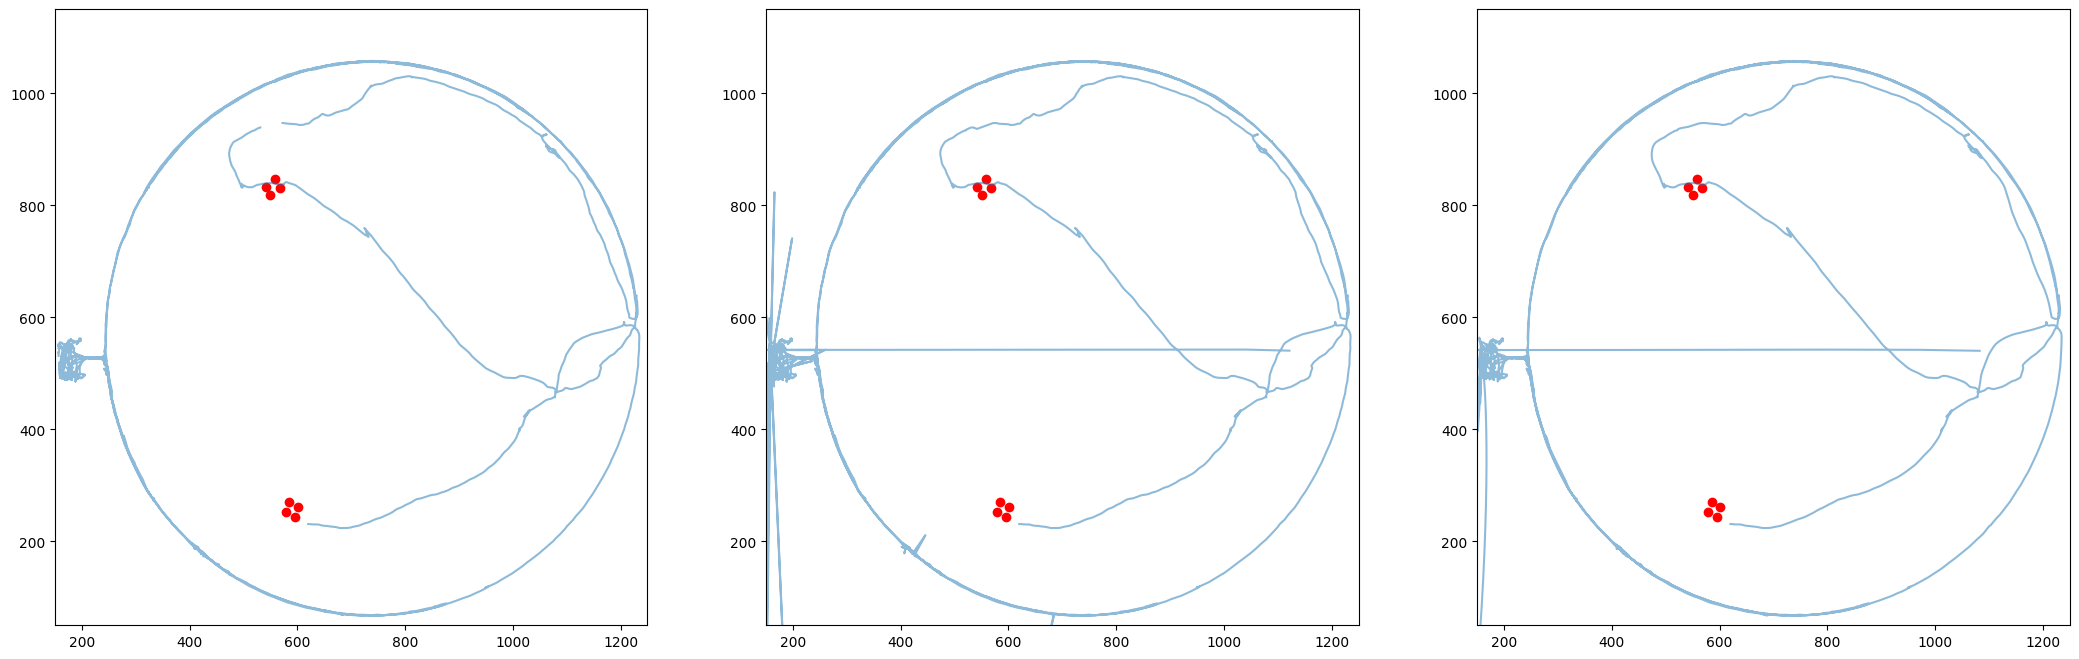

2022-05-25 12:45:00
2022-05-25 12:50:00


/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/inference.py:359: RuntimeWarning: overflow encountered in matmul
  logLike = logLike-np.linalg.slogdet(Sn[:, :, k])[1] - innov[:, :, k].T @ Sinv @ innov[:, :, k]


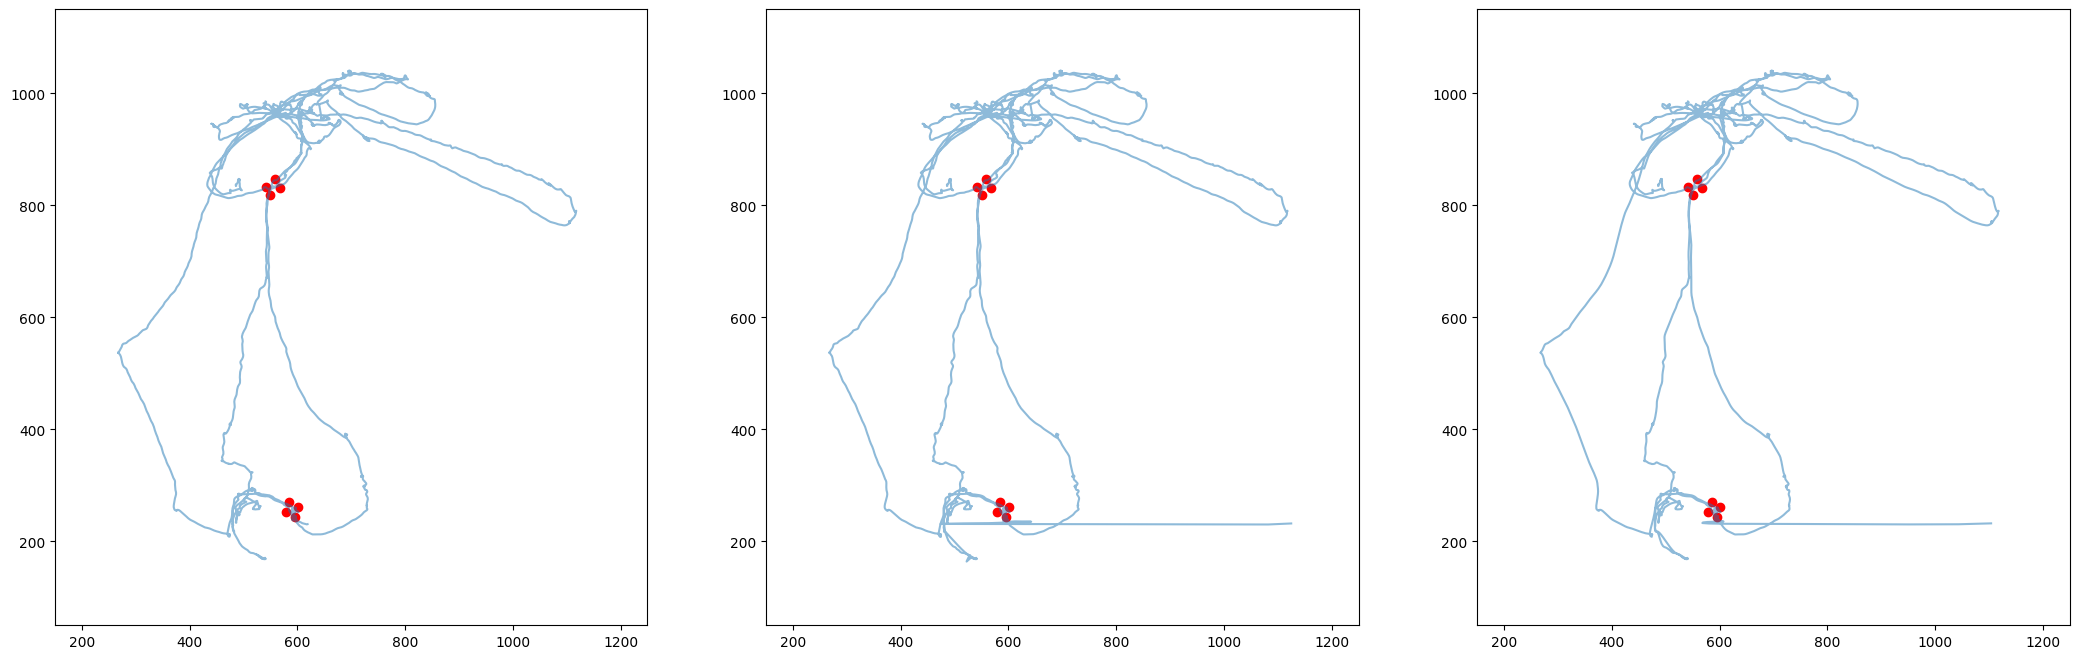

2022-05-25 12:50:00
2022-05-25 12:55:00


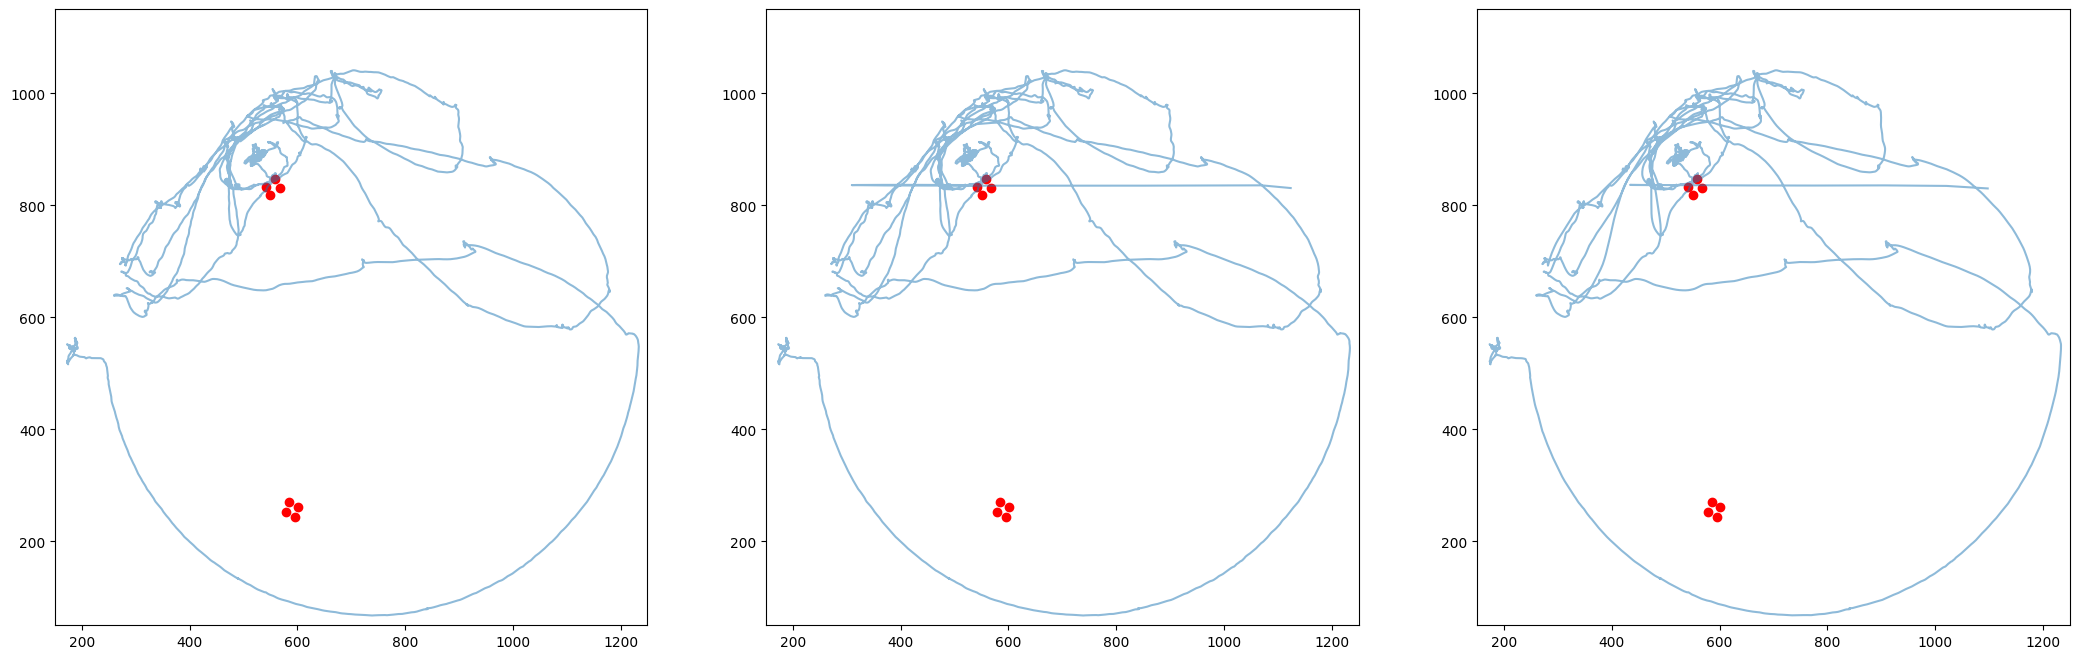

2022-05-25 12:55:00
2022-05-25 13:00:00


/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/inference.py:359: RuntimeWarning: overflow encountered in matmul
  logLike = logLike-np.linalg.slogdet(Sn[:, :, k])[1] - innov[:, :, k].T @ Sinv @ innov[:, :, k]


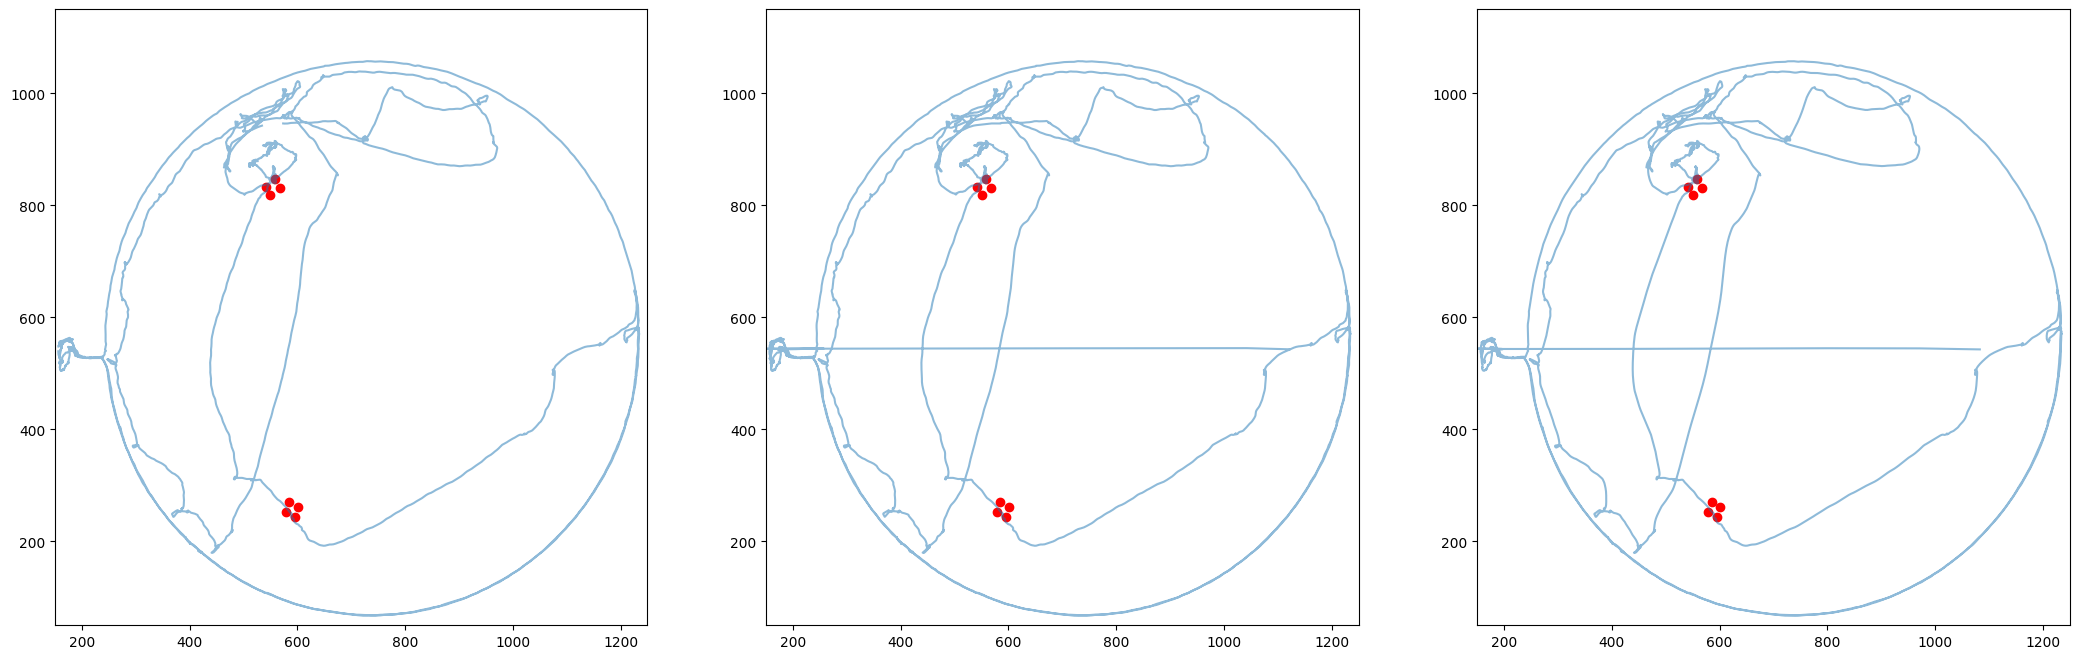

In [34]:
# Load mice 15 - BAA-1100703
for i in range(0, 12):
    start_time, end_time = GenerateTime(d='2022-05-25', h=12,m=i*5,s=0), GenerateTime(d='2022-05-25', h=12,m=(i+1)*5,s=0)
    start, end = pd.Timestamp(start_time), pd.Timestamp(end_time)
    print(start)
    print(end)
    
    mouse_sub_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
    obs = np.transpose(mouse_sub_pos[["x", "y"]].to_numpy())


    filterRes = inference.filterLDS_SS_withMissingValues_np(
        y=obs, B=B, Q=Q, m0=m0, V0=V0, Z=Z, R=R)
    filter_mean_x = filterRes["xnn"][0][0]
    filter_mean_y = filterRes["xnn"][3][0]

    smoothRes = inference.smoothLDS_SS(
        B=B, xnn=filterRes["xnn"], Vnn=filterRes["Vnn"],
        xnn1=filterRes["xnn1"], Vnn1=filterRes["Vnn1"], m0=m0, V0=V0)

    smoothed_mean_x = smoothRes['xnN'][0][0]
    smoothed_mean_y = smoothRes['xnN'][3][0]

    xlim, ylim = (150, 1250), (50, 1150)
    fig, axs = plt.subplots(1, 3, figsize = (26,8))
    axs[0].plot(obs[0], obs[1], alpha=0.5)
    axs[0].set_xlim(xlim)
    axs[0].set_ylim(ylim)

    axs[1].plot(filter_mean_x, filter_mean_y, alpha=0.5)
    axs[1].set_xlim(xlim)
    axs[1].set_ylim(ylim)

    axs[2].plot(smoothed_mean_x, smoothed_mean_y, alpha=0.5)
    axs[2].set_xlim(xlim)
    axs[2].set_ylim(ylim)

    for patch in Patch_Pos:
        patch_pos = [(int(pos['X']), int(pos['Y'])) for pos in patch]
        for pos in patch_pos: 
            axs[0].scatter(pos[0], pos[1], color = 'red')
            axs[1].scatter(pos[0], pos[1], color = 'red')
            axs[2].scatter(pos[0], pos[1], color = 'red')
    plt.show()